## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split , GridSearchCV, cross_validate, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score \
   , precision_score, precision_recall_curve, ConfusionMatrixDisplay, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# EXPLORATORY DATA ANALYSIS (EDA) & VISUALIZATION

## 1. Read, Inspect, and Cleaning Data

In [2]:
def read_inspect_data(path):
    df = pd.read_csv(path)
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe().T)
    print("\nDescriptive statistics for object (categorical) columns:")
    print(df.describe(include='object').T)
    print("\nNumber of duplicated rows:")
    print(df.duplicated().sum())
    print("\nNumber of missing values in each column:")
    print(df.isna().mean())
    print("\nNumber of unique values in each column:")
    print(df.nunique())
    return df

stroke = read_inspect_data('healthcare-dataset-stroke-data.csv')

First 5 rows of the dataset:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

DataFrame Info:
<class 'pa

The column of 'Residence_type' begins with uppercase while others are not. To make a standardize grammer to prevent mistake we will change all column names into lowercase

In [3]:
stroke.columns = stroke.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

In [4]:
pd.DataFrame({'Null Count': stroke.isnull().sum(), 
                          'Null Percentage %': stroke.isnull().mean()*100}).sort_values(by='Null Percentage %', ascending=False).T

,bmi,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,smoking_status,stroke
Null Count,201.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Null Percentage %,3.933464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the given dataset, there have been 201 missing values in the column of "bmi". These missing values will be handled with after Train & Split process for preventing data leakage.

• In this dataset, target variable is coded as 1 for positive cases (having stroke) and 0 for negative cases (not having stroke).

• Both Hypertension and heart disease have integer data types, not as an object.

• Like our Target variable (stroke), both hypertension and heart_disease are coded as 1 for the positive cases and 0 for negative cases.

<Axes: >

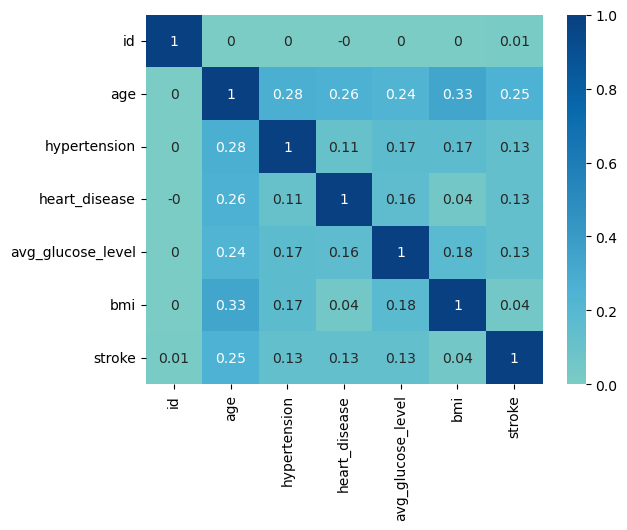

In [5]:
sns.heatmap(round(stroke.corr(numeric_only=True), 2), annot=True, cmap='GnBu', center=0)

In [6]:
stroke.quantile([0, 0.1, 0.25, 0.9, 0.95, 0.99, 0.999, 1], numeric_only=True).T

,0.000,0.100,0.250,0.900,0.950,0.990,0.999,1.000
id,67.00,6972.500,17741.250,65667.600,69217.9500,72264.6700,72880.36500,72940.00
age,0.08,11.000,25.000,75.000,79.0000,82.0000,82.00000,82.00
hypertension,0.00,0.000,0.000,0.000,1.0000,1.0000,1.00000,1.00
heart_disease,0.00,0.000,0.000,0.000,1.0000,1.0000,1.00000,1.00
avg_glucose_level,55.12,65.789,77.245,192.181,216.2945,240.7082,263.53384,271.74
bmi,10.30,19.700,23.500,38.900,42.9600,53.4000,64.98400,97.60
stroke,0.00,0.000,0.000,0.000,0.0000,1.0000,1.00000,1.00


In [7]:
numerical= stroke.drop(['stroke'], axis=1).select_dtypes('number').columns

categorical = stroke.select_dtypes('object').columns

print("\033[1m", "Numerical Columns:", "\033[0;0m",  numerical)
print("------------------------------------------------------------------------------------------------------------------")
print("\033[1m", "Categorical Columns:", "\033[0;0m", categorical)

 Numerical Columns:  Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi'],
      dtype='object')
------------------------------------------------------------------------------------------------------------------
 Categorical Columns:  Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')


## 2. Visualize Key Features

In [8]:
def count_plot(data, col, hue):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.countplot(data=data, x=col, ax=axes[0])
    axes[0].set_title(f'Count of {col}')
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].text(p.get_x() + p.get_width() / 2., height + 0.1,
                    f'{int(height)}',
                    ha='center', va='bottom')


    sns.countplot(data=data, x=col, hue=hue, ax=axes[1])
    axes[1].set_title(f'{col} vs. {hue}')
    for p in axes[1].patches:
        height = p.get_height()
        if height > 0:
            axes[1].text(p.get_x() + p.get_width() / 2., height + 0.1,
                        f'{int(height)}',
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


    print('Unique values\n', data[col].unique())
    print('Value Counts\n', data[col].value_counts())


def distribution(data, col1, col2):
    print(f"Number of unique {col1}: {data[col1].nunique()}")

    # Distribution plot of {col1}
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col1], kde=True)
    plt.title(f'Distribution of {col1}')
    plt.xlabel(f'{col1}')
    plt.ylabel('Frequency')
    plt.show()

    # Box plot of {col1} vs. stroke
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, x=col2, y=col1)
    plt.title(f'{col1} Distribution by {col2} Outcome')
    plt.xlabel('Stroke (0: No Stroke, 1: Stroke)')
    plt.ylabel(f'{col1}')
    plt.xticks([0, 1], ['No Stroke', 'Stroke'])  # Improve x-axis labels
    plt.grid(True, axis='y', linestyle='--')  # Add a subtle grid for better readability
    plt.show()

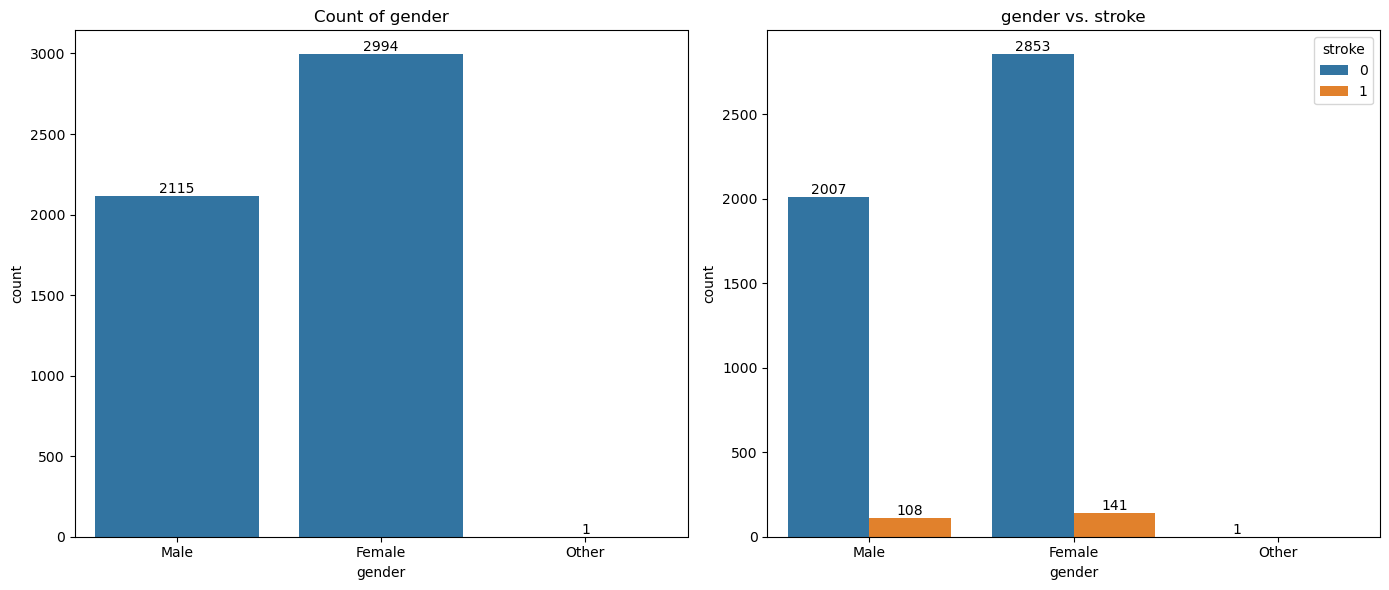

Unique values
 ['Male' 'Female' 'Other']
Value Counts
 gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
Number of unique age: 104


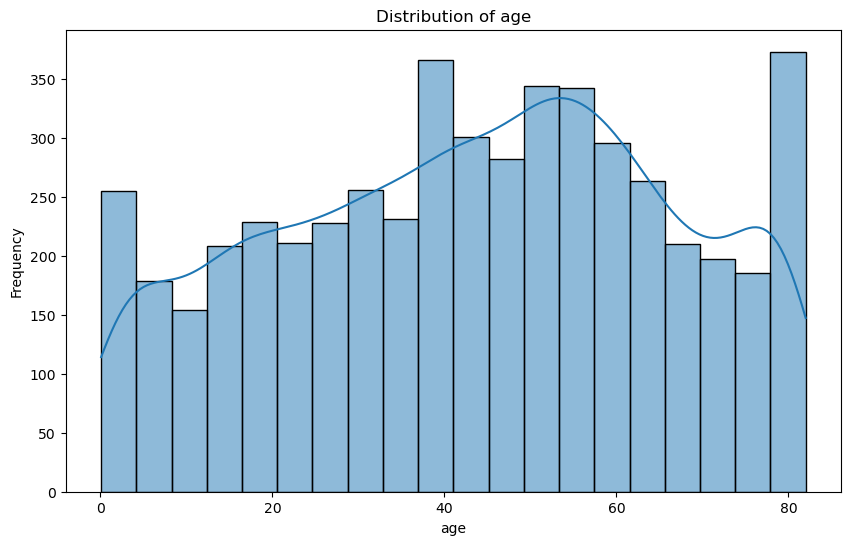

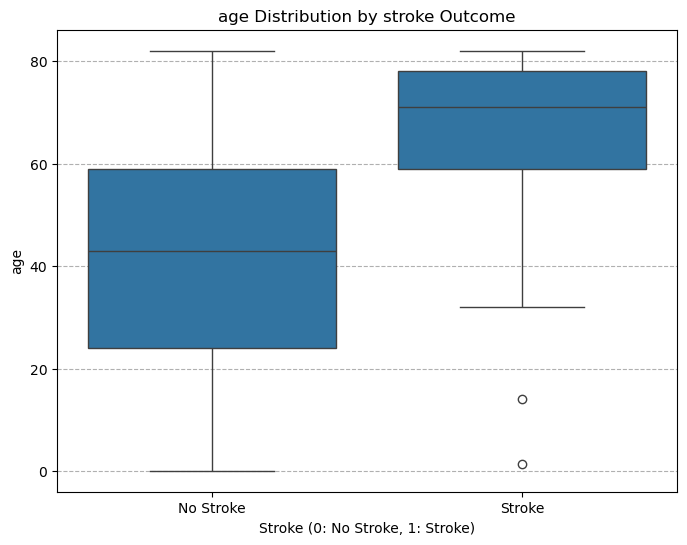

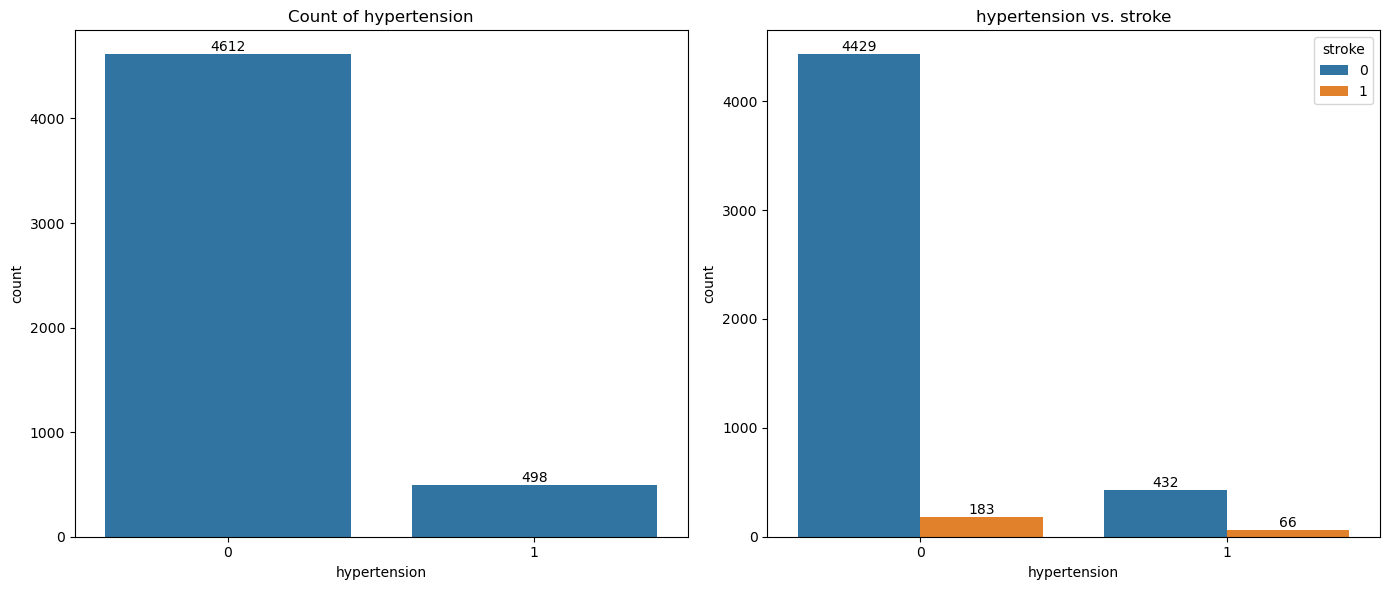

Unique values
 [0 1]
Value Counts
 hypertension
0    4612
1     498
Name: count, dtype: int64


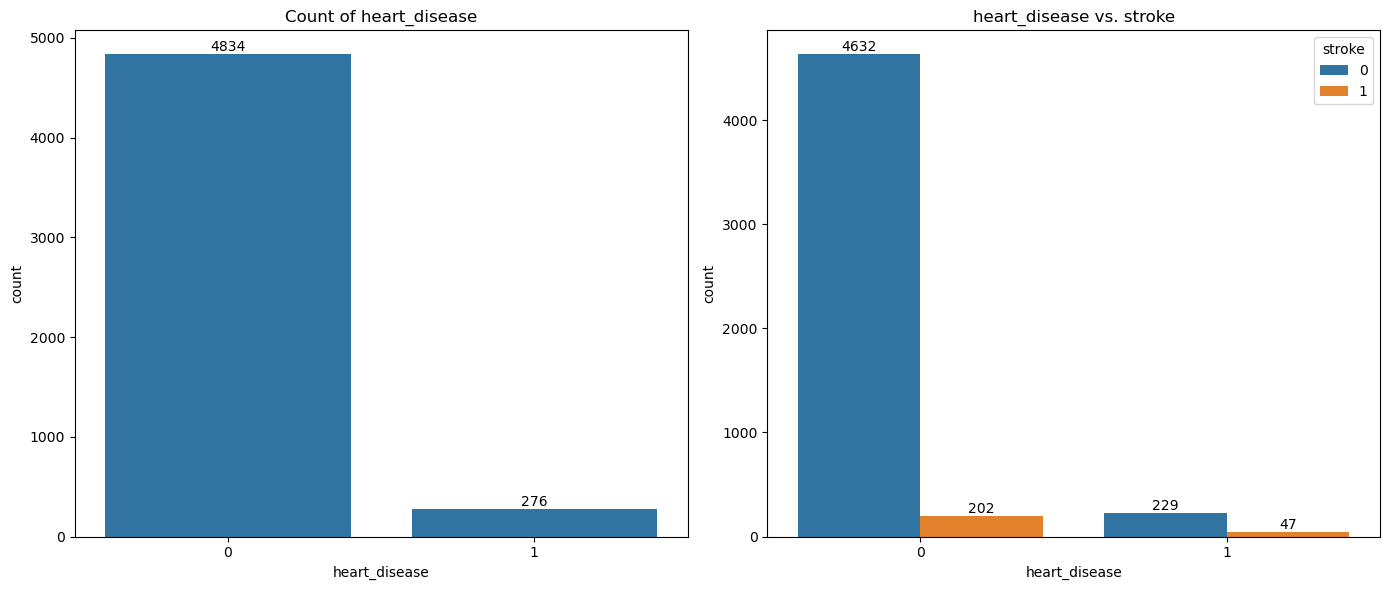

Unique values
 [1 0]
Value Counts
 heart_disease
0    4834
1     276
Name: count, dtype: int64


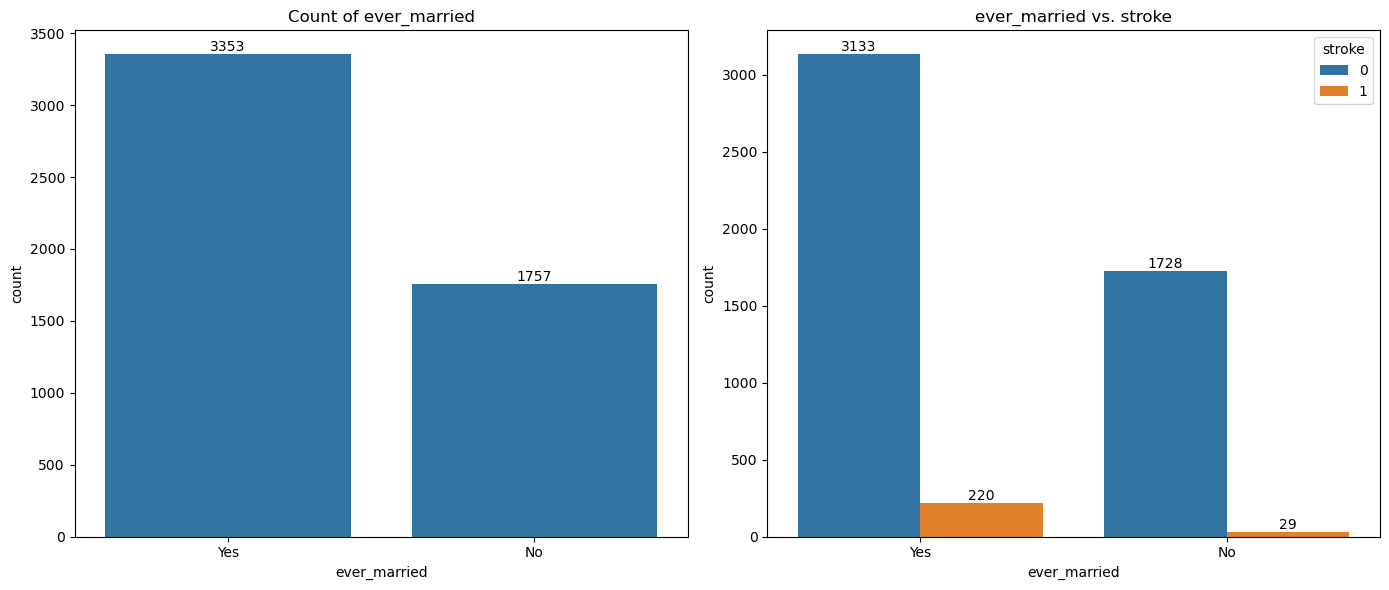

Unique values
 ['Yes' 'No']
Value Counts
 ever_married
Yes    3353
No     1757
Name: count, dtype: int64


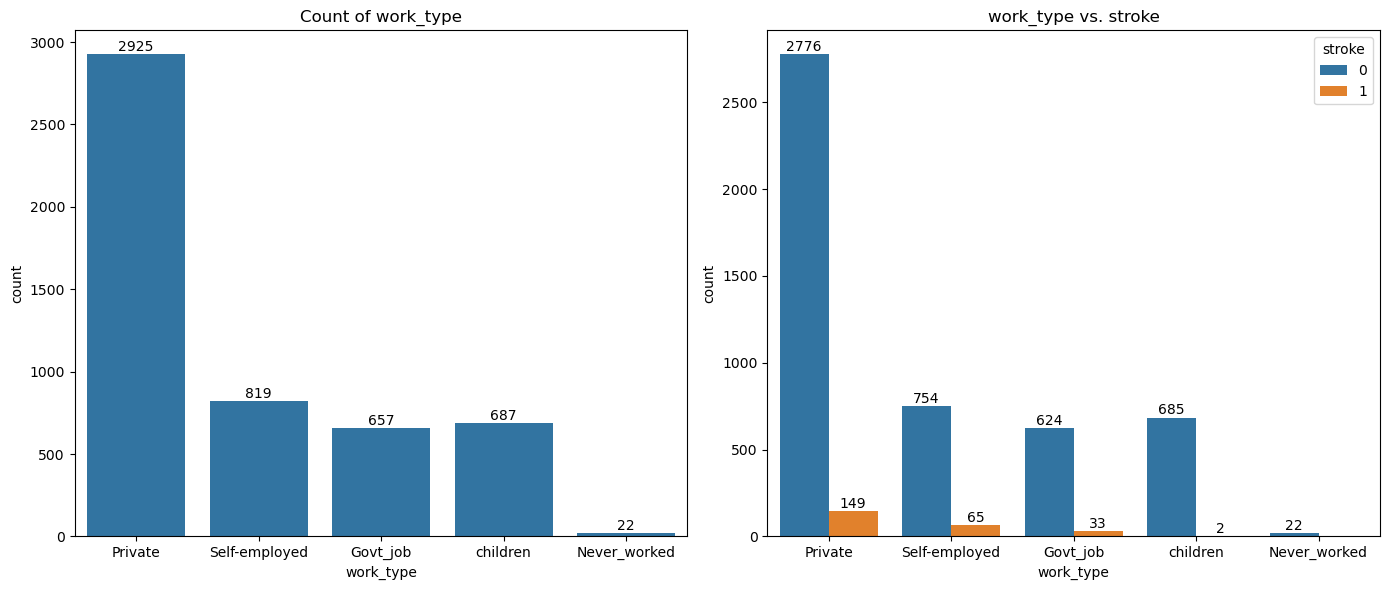

Unique values
 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Value Counts
 work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


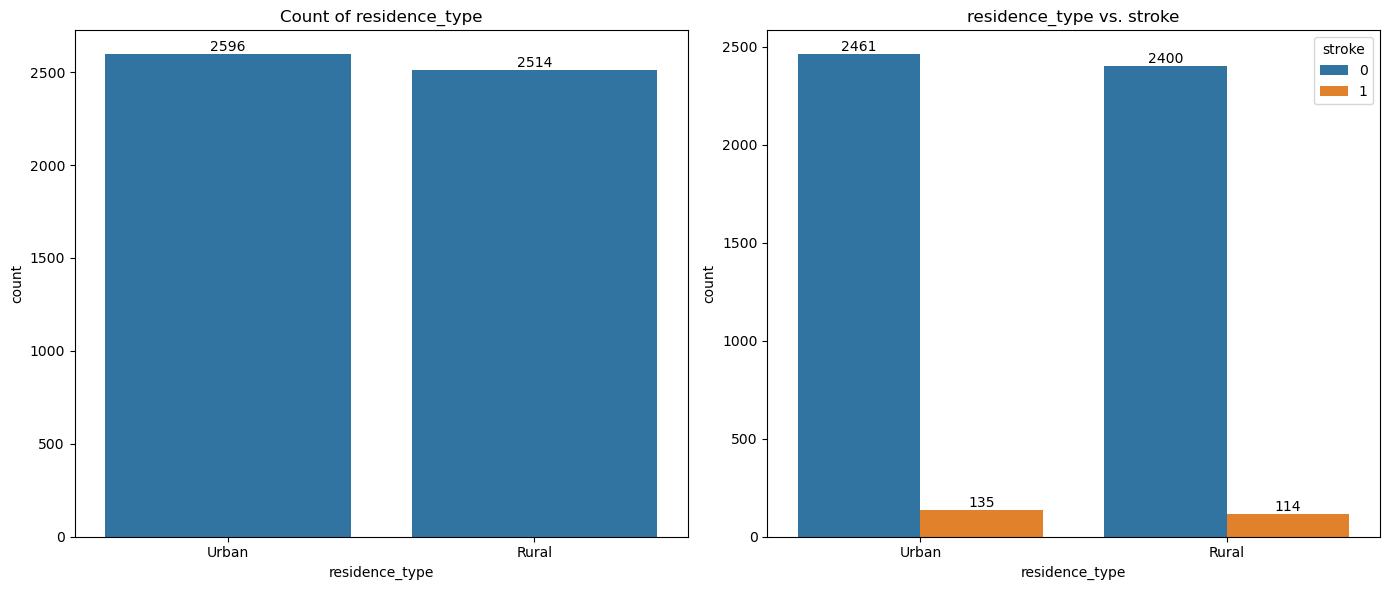

Unique values
 ['Urban' 'Rural']
Value Counts
 residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


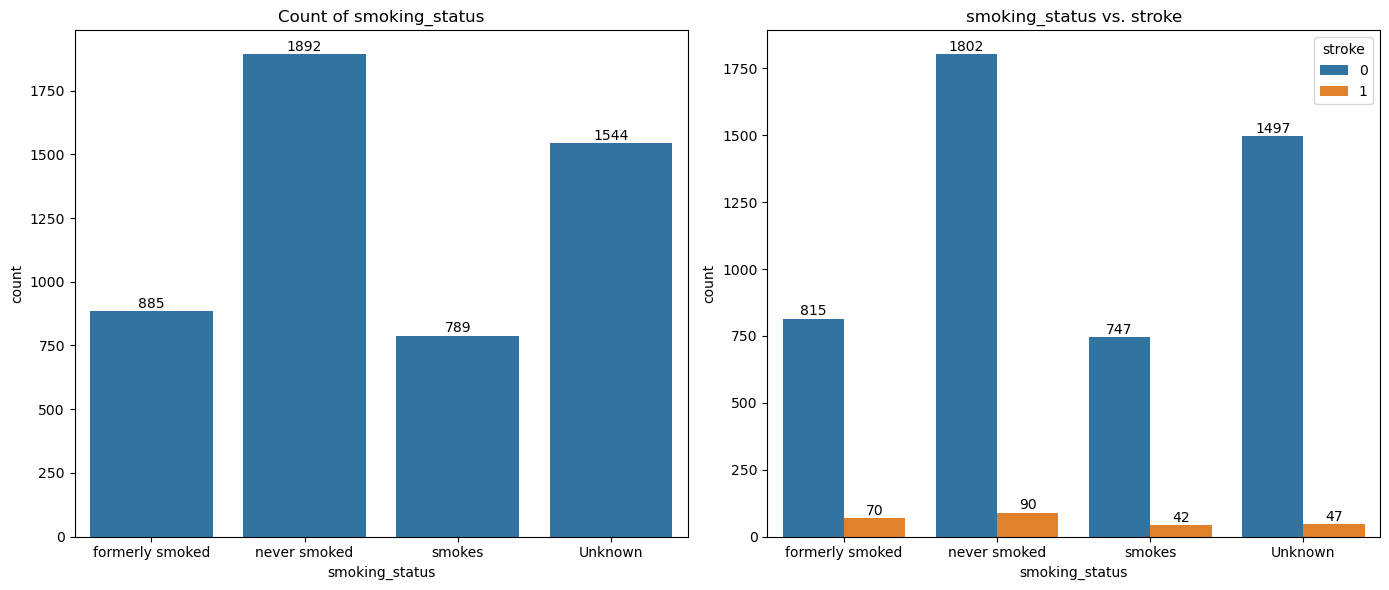

Unique values
 ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
Value Counts
 smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
Number of unique avg_glucose_level: 3979


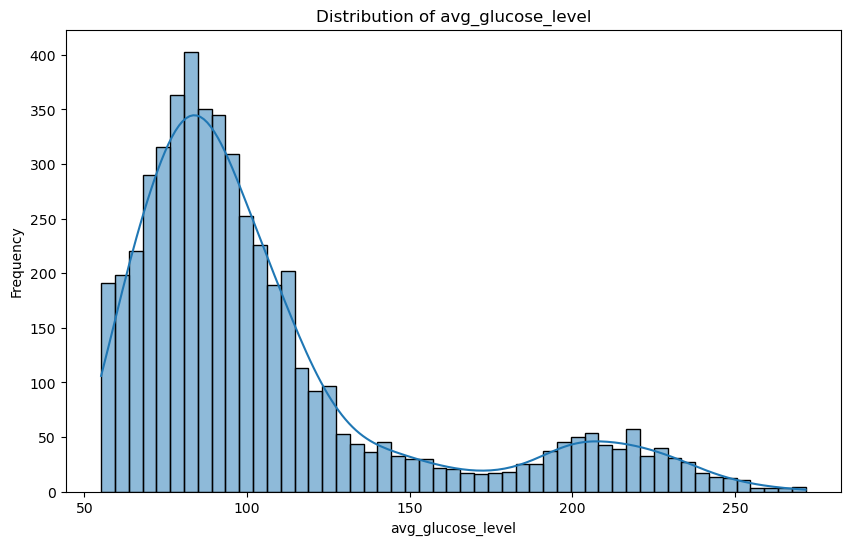

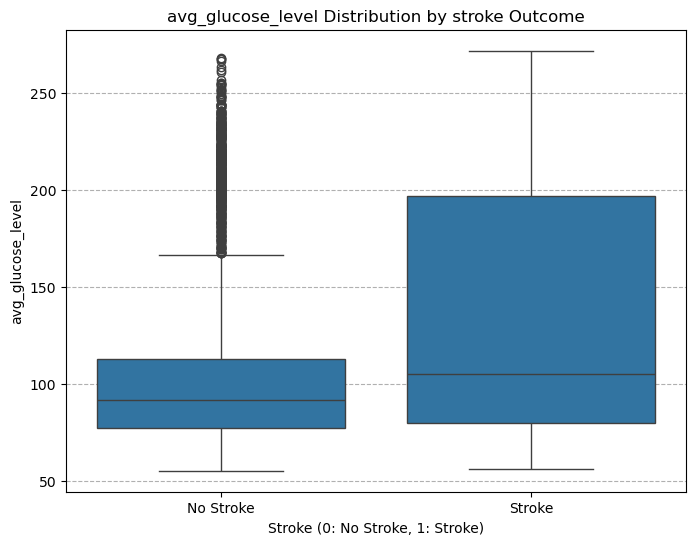

Number of unique bmi: 418


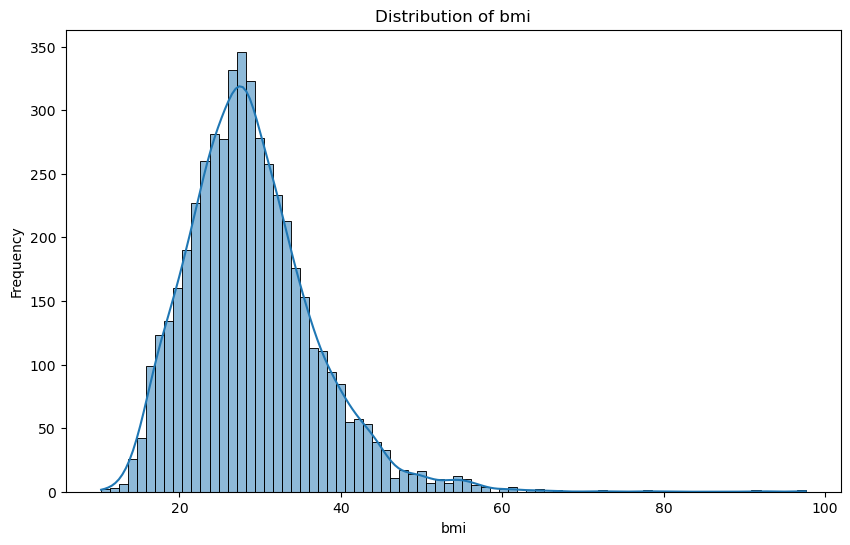

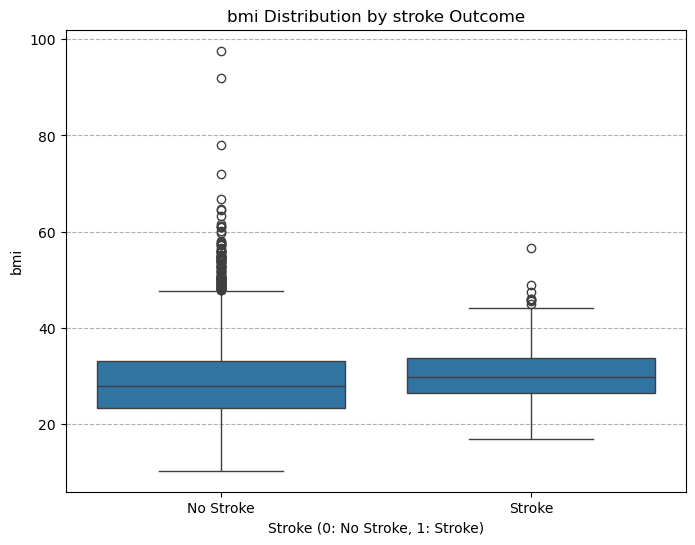

In [9]:
count_plot(stroke, 'gender', 'stroke')
distribution(stroke, 'age', 'stroke')
count_plot(stroke,'hypertension', 'stroke')
count_plot(stroke, 'heart_disease', 'stroke')
count_plot(stroke, 'ever_married', 'stroke')
count_plot(stroke, 'work_type', 'stroke')
count_plot(stroke, 'residence_type', 'stroke')
count_plot(stroke, 'smoking_status', 'stroke')
distribution(stroke, 'avg_glucose_level', 'stroke')
distribution(stroke, 'bmi', 'stroke')

**A. Distribution of Strokes (Target Variable)**

The proportion of target variable is one of the most important things in a classification problem. So let's a close look at how its values are distributed.

Percentage of patient has a stroke: % 4.87 -->     (249 patient)
Percentage of patient does not have a stroke: % 95.13 -->       (4861 patient)


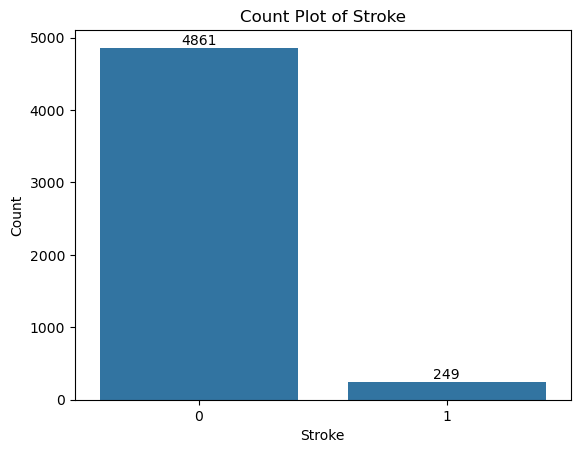

In [12]:
target = stroke['stroke']
print(f'Percentage of patient has a stroke: % {round(target.value_counts(normalize=True)[1]*100,2)} -->\
     ({target.value_counts()[1]} patient)\nPercentage of patient does not have a stroke: % {round(target.value_counts(normalize=True)[0]*100,2)} -->\
       ({target.value_counts()[0]} patient)')

ax = sns.countplot(data=stroke, x='stroke')

# Iterate through the bars and add the count
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            f'{int(height)}',
            ha='center', va='bottom')

plt.title('Count Plot of Stroke')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

In this sense, almost %95 of the instances in our target variable haven't experienced with 'stroke' representing 4861 patients.

On the other hand %5 of the instances in our target variable go through 'Stroke' representing 249 patient.

Similarly, it's clear that the proportinate distribution for each class is not the case here. So we should assume an imbalanced data we have in the given case.

Helps check if the dataset is imbalanced (usually, stroke cases are rare).

In [13]:
stroke[stroke['stroke']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
id,4861.000000,36487.236371,21120.133386,67.000000,17762.000000,36958.000000,54497.000000,72940.000000
age,4861.000000,41.971545,22.291940,0.080000,24.000000,43.000000,59.000000,82.000000
hypertension,4861.000000,0.088871,0.284586,0.000000,0.000000,0.000000,0.000000,1.000000
heart_disease,4861.000000,0.047110,0.211895,0.000000,0.000000,0.000000,0.000000,1.000000
avg_glucose_level,4861.000000,104.795513,43.846069,55.120000,77.120000,91.470000,112.830000,267.760000
bmi,4700.000000,28.823064,7.908287,10.300000,23.400000,28.000000,33.100000,97.600000
stroke,4861.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


**B. Numerical Features**

In [14]:
stroke[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60


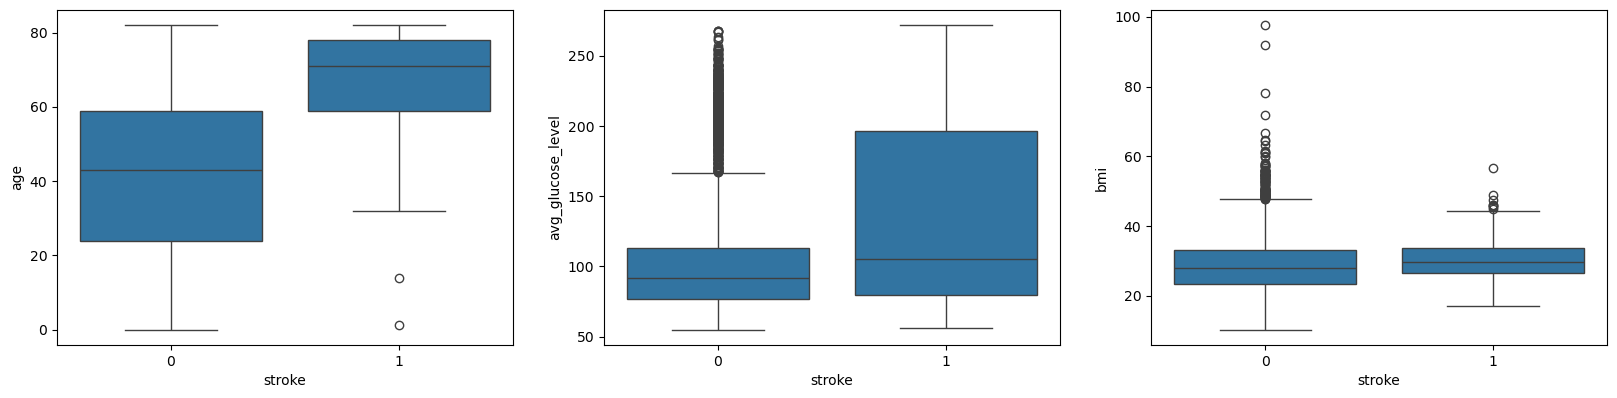

In [15]:
index = 0
plt.figure(figsize=(20,20))
for feature in stroke[numerical].drop(columns=['id','hypertension', 'heart_disease']).columns:
    if feature != "stroke":
        index += 1
        plt.subplot(4,3,index)
        sns.boxplot(x='stroke', y=feature, data=stroke)

**Handle Weired Type in Gender *'Other'* By drop it**

In the "gender" column there has been an undefined classification which makes no contribution to understand stroke. So let's discard this row from the analysis.

In [4]:
stroke.drop(stroke[stroke['gender'] == 'Other'].index, inplace=True)
stroke.drop(columns=['id'], inplace=True)
stroke.shape

(5109, 11)

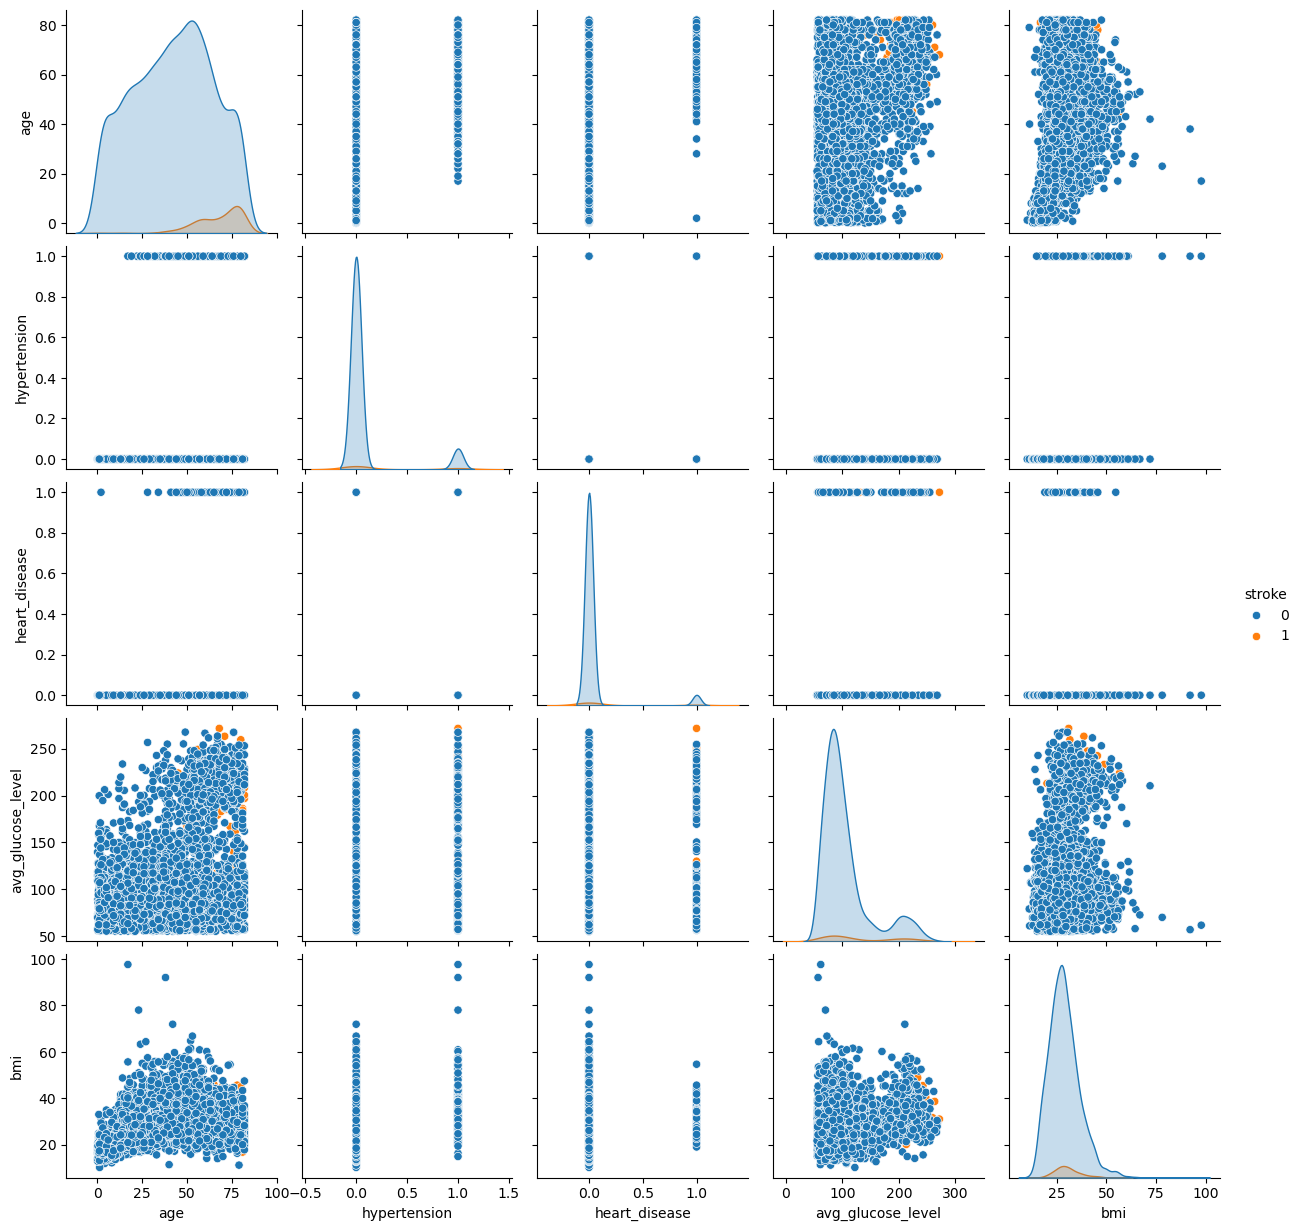

In [17]:
sns.pairplot(stroke, hue="stroke")

### Feature Engineering

In [17]:
stroke_visualize = stroke.copy()

In [18]:
stroke_visualize['bmi'] = stroke_visualize['bmi'].transform(lambda x: x.fillna(x.median()))

In [19]:
stroke_visualize.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

**Handle Outliers**

In [21]:
# Filter out BMI > 80 and avg_glucose_level > 250
stroke_visualize = stroke_visualize[
    (stroke_visualize['bmi'] <= 80) & 
    (stroke_visualize['avg_glucose_level'] <= 250)
]

In [13]:
# Age Groups
stroke_visualize['age_group'] = pd.cut(stroke_visualize['age'], bins=[0,15,25,65,100], 
                                  labels=['Children (00-14 years)', 'Youth (15-24 years)', 'Adults (25-64 years)', 'Seniors (65 years and over)'])

# Glucose level categories
stroke_visualize['glucose_category'] = pd.cut(stroke_visualize['avg_glucose_level'], 
                                         bins=[0, 70, 99, 125, float('inf')], 
                                         labels=['Low', 'Normal', 'Prediabetes', 'Diabetes'])

# BMI Categories
stroke_visualize['bmi_category'] = pd.cut(stroke_visualize['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')], 
                                     labels=['Underweight', 'Normal weight', 'Overweight','Obese'])

**B. Age vs. Stroke**

**Does age significantly affect stroke risk?**

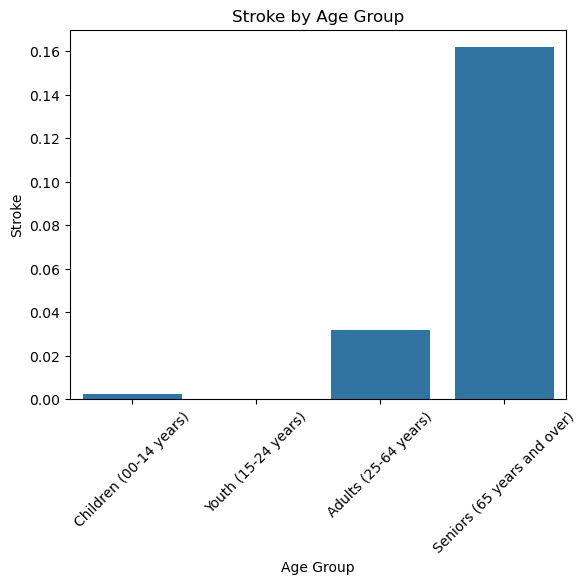

In [14]:
sns.barplot(data=stroke_visualize, x='age_group', y='stroke', errorbar=None)
plt.xticks(rotation=45)
plt.title('Stroke by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Stroke')
plt.show()

Older patients tend to have higher stroke risk.

**C. Glucose Levels & BMI Analysis**

**Are high glucose levels linked to higher stroke risk?**

**Does BMI (Body Mass Index) influence stroke likelihood?**

NameError: name 'stroke_visualize' is not defined

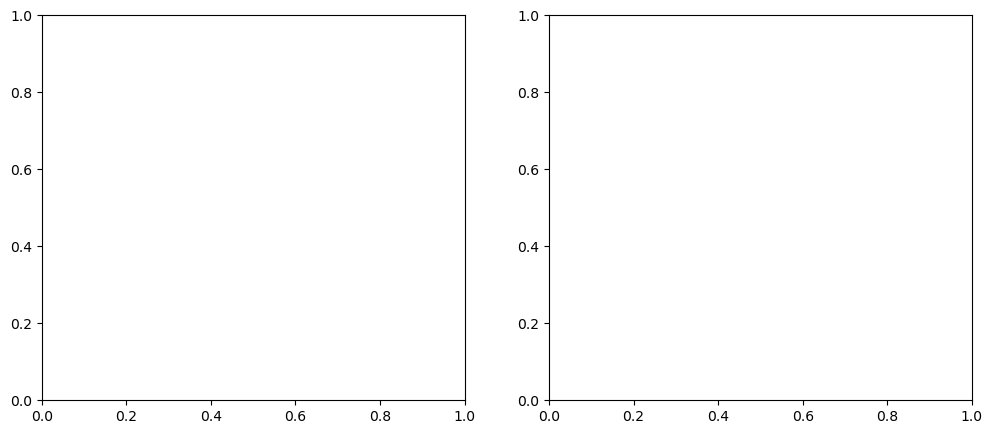

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(y='stroke', x='glucose_category', data=stroke_visualize, ax=axes[0], errorbar=None)
sns.barplot(y='stroke', x='bmi_category', data=stroke_visualize, ax=axes[1], errorbar=None)
plt.suptitle("Glucose & BMI vs. Stroke")
plt.show()

In [15]:
cat_features = ['bmi_category', 'glucose_category']
for feature in cat_features:
    # Group the data by the feature and stroke status
    data = stroke_visualize.groupby([feature, 'stroke']).size().unstack()

    # Create pie chart for stroke = 1 (stroke cases)
    plt.figure(figsize=(8, 6))
    plt.pie(data.loc[:, 1], labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(f"Distribution of Stroke Cases by {feature}")
    plt.ylabel("")  # Remove default ylabel
    plt.show()

NameError: name 'stroke_visualize' is not defined

High glucose levels may correlate with stroke risk.

**D. Hypertension & Heart Disease Impact**

**How do hypertension and heart disease relate to stroke?**

NameError: name 'stroke_visualize' is not defined

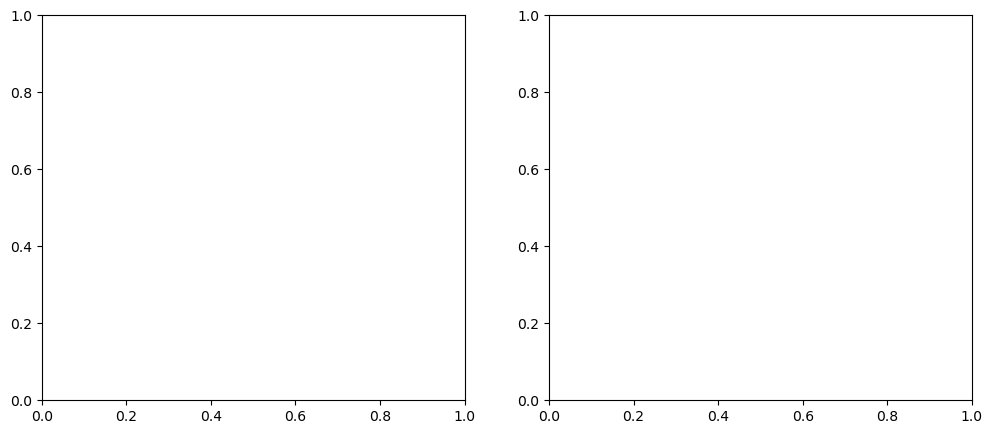

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(x='hypertension', hue='stroke', data=stroke_visualize, ax=axes[0], multiple='dodge')
sns.histplot(x='heart_disease', hue='stroke', data=stroke_visualize, ax=axes[1], multiple='dodge')
plt.suptitle("Impact of Hypertension & Heart Disease on Stroke")
plt.show()

In [13]:
sns.pairplot(data=stroke_visualize, hue='stroke', x_vars='hypertension', y_vars='heart_disease')

NameError: name 'stroke_visualize' is not defined

Patients with hypertension or heart disease may have a higher stroke risk.

**E. Categorical Features (Gender, Smoking, Work Type, Residence Type, Martial Status)**

**Is gender a strong predictor of stroke?**

**Does smoking status (current/former/never) impact stroke probability?**

**Do certain work types (private, self-employed, govt jobs) have different stroke risks?**

**Are married individuals more/less likely to have strokes?**

**Do urban/rural residents have different stroke rates?**

In [12]:
cat_features = ['gender', 'smoking_status', 'work_type', 'ever_married', 'residence_type']
for feature in cat_features:
    # Group the data by the feature and stroke status
    data = stroke_visualize.groupby([feature, 'stroke']).size().unstack()
    data.loc[:, 1] = data.loc[:, 1].fillna(0)  # Handle NaN values

    # Create pie chart for stroke = 1 (stroke cases)
    plt.figure(figsize=(8, 6))
    plt.pie(data.loc[:, 1], labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(f"Distribution of Stroke Cases by {feature}")
    plt.ylabel("")  # Remove default ylabel
    plt.show()

NameError: name 'stroke_visualize' is not defined

In [11]:
# Group by gender and BMI category to get the count of each category
bmi_by_gender = stroke_visualize.groupby(['gender', 'bmi_category']).size().unstack()

# Plot a pie chart for each gender
gender_list = stroke_visualize['gender'].unique()
for gender in gender_list:
    plt.figure(figsize=(7, 7))
    bmi_by_gender.loc[gender].plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
    plt.title(f'BMI Categories for {gender}')
    plt.ylabel('')  # Remove the y-axis label
    plt.show()

NameError: name 'stroke_visualize' is not defined

**Is there a relationship between gender and bmi?**

In [30]:
# Descriptive statistics for BMI by gender
bmi_by_gender = stroke_visualize.groupby('gender')['bmi'].describe()
print(bmi_by_gender)

         count       mean       std   min   25%   50%    75%   max
gender                                                            
Female  2979.0  29.018429  7.981317  10.3  23.4  28.1  33.30  78.0
Male    2103.0  28.556443  7.006239  11.5  24.2  28.1  32.25  71.9


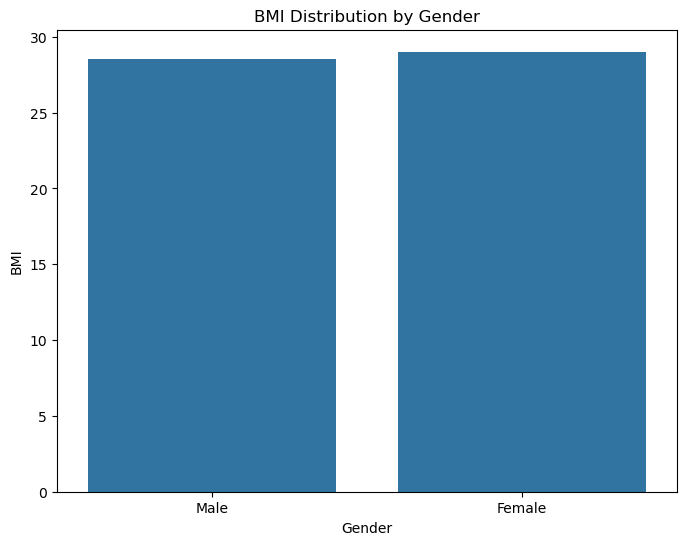

In [31]:
plt.figure(figsize=(8, 6))
sns.barplot(data=stroke_visualize, x='gender', y='bmi', errorbar=None)
plt.title('BMI Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('BMI')
plt.show()

**Is bmi affected by age?**

In [32]:
# Calculate the correlation between age and BMI
correlation = stroke_visualize[['age', 'bmi']].corr().iloc[0, 1]
print(f"Correlation between Age and BMI: {correlation}")

Correlation between Age and BMI: 0.33152756220240415


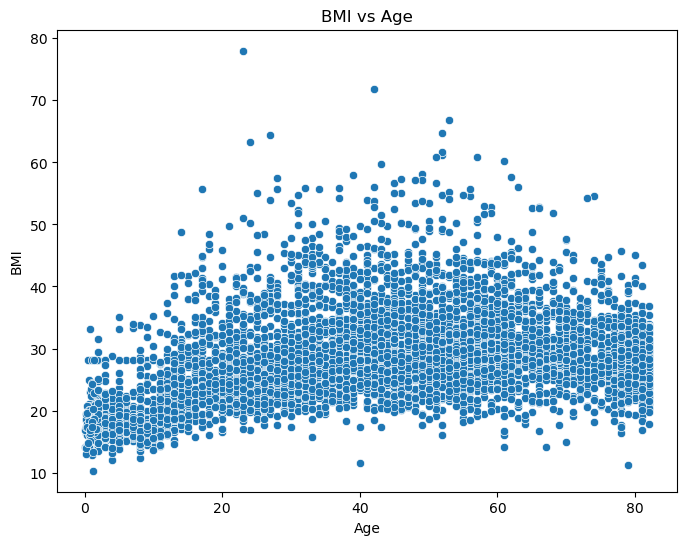

In [33]:
# Scatter plot with age on the x-axis and BMI on the y-axis
plt.figure(figsize=(8, 6))
sns.scatterplot(data=stroke_visualize, x='age', y='bmi')
plt.title('BMI vs Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

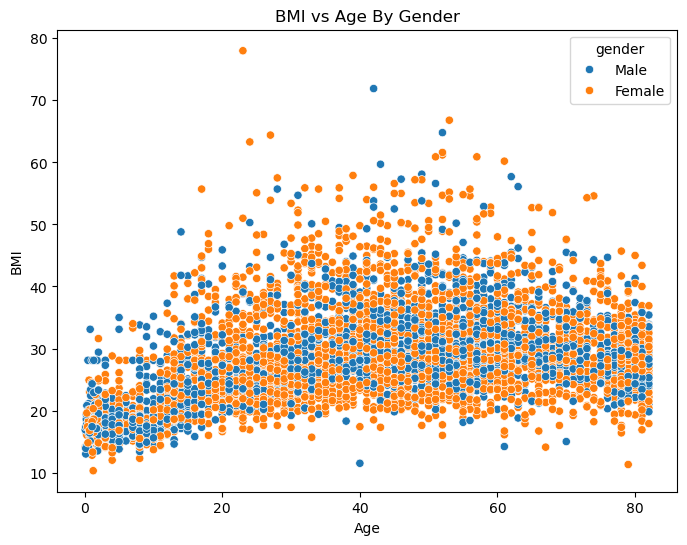

In [34]:
# Scatter plot with age on the x-axis and BMI on the y-axis grouped by gender
plt.figure(figsize=(8, 6))
sns.scatterplot(data=stroke_visualize, x='age', y='bmi', hue='gender')
plt.title('BMI vs Age By Gender')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

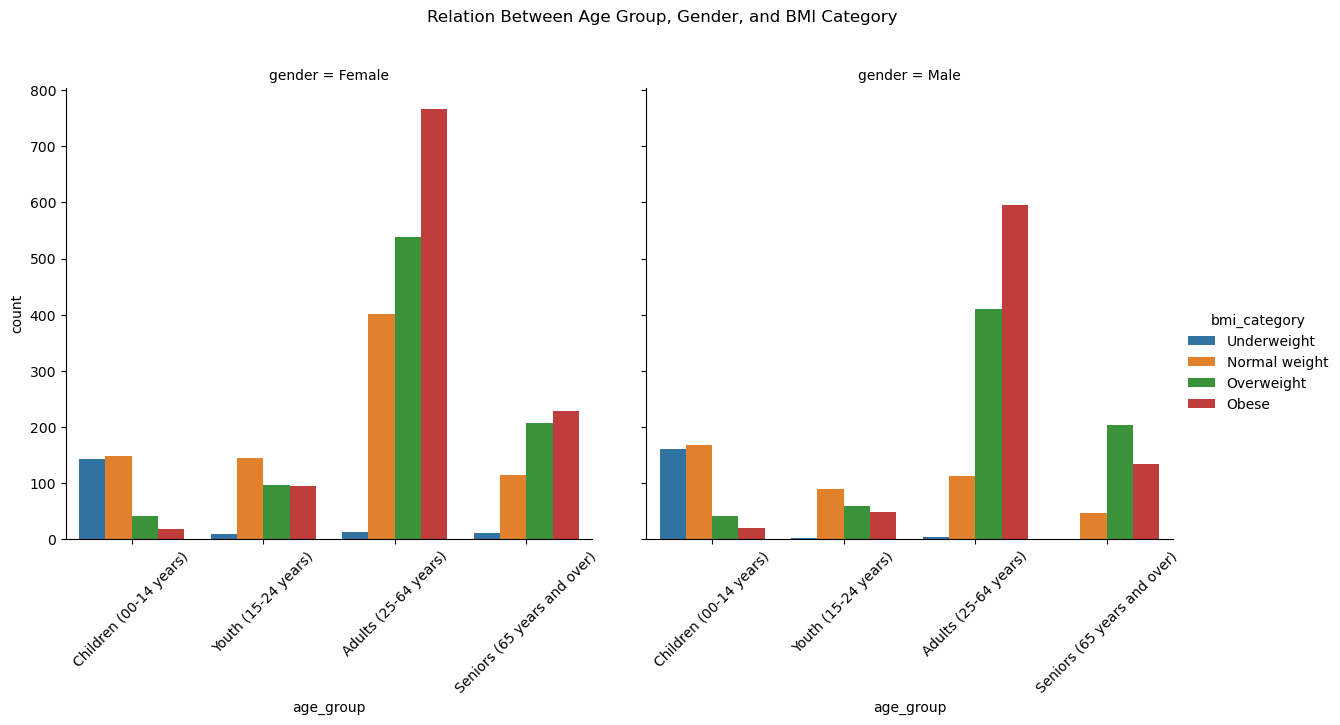

In [35]:
# Group data by age group, gender, and BMI category
grouped_data = stroke_visualize.groupby(['age_group', 'gender', 'bmi_category']).size().reset_index(name='count')

cat_plot = sns.catplot(data=grouped_data, x='age_group', y='count', hue='bmi_category', col='gender', kind='bar', errorbar=None, height=6, aspect=1)
cat_plot.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
plt.suptitle("Relation Between Age Group, Gender, and BMI Category")
plt.show()

In [36]:
stroke_visualize.to_csv('stroke_labeled.csv')

# Machine Learning

In [72]:
stroke_labeled = stroke.copy()
print(stroke_labeled.nunique())
print(stroke_labeled.isna().sum())
print(stroke_labeled.dtypes)
print(stroke_labeled.columns)

gender                  2
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
residence_type          2
avg_glucose_level    3978
bmi                   418
smoking_status          4
stroke                  2
dtype: int64
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object
Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       

## Data Preprocessing, Splitting, Balancing, Scaling

• we have 4 nominal categorical variables, which needs to be converted to Label Encoder.

• we have 3 ordinal categorical variables, which needs to be converted to OneHotEncoder.

• we have 3 Numerical variables, which needs to be scaled by StandardScaler.

### right code

In [ ]:
# Step 1: Remove outliers
stroke_labeled = stroke_labeled[
    (stroke_labeled['bmi'] <= 80) & (stroke_labeled['avg_glucose_level'] <= 250)
]

# Step 2: Split before defining columns (important!)
X = stroke_labeled.drop("stroke", axis=1)
y = stroke_labeled["stroke"].copy()

# Step 3: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Define column types AFTER split so they match the data
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()
cat_cols = X_train.select_dtypes(include="object").columns.tolist()

# Step 5: Define transformers for numeric and categorical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Step 6: Combine into preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
]).set_output(transform='pandas')

# Step 7: Apply preprocessing
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Step 8: Apply SMOTE for class balancing
sampler = SMOTE(random_state=42)
X_sample, y_sample = sampler.fit_resample(X_train_prep, y_train)
print(f"X_train_resampled shape: {X_sample.shape}, y_train_resampled shape: {y_sample.shape}")

X_train_resampled shape: (7486, 15), y_train_resampled shape: (7486,)


## Modeling

### Quick Modeling

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42, max_depth=5),
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5)
}

for name, model in models.items():
    scores = cross_val_score(model, X_sample, y_sample, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    print(f'{name} RMSE: {rmse_scores.mean()}')

Random Forest RMSE: 0.3907447771581694
Logistic Regression RMSE: 0.4499489982994097
Decision Tree RMSE: 0.42358554938696125


Accuracy: 0.9314227226202662
F1 Score: 0.056338028169014086
AUC Score: 0.7685272045028142

Confusion Matrix:


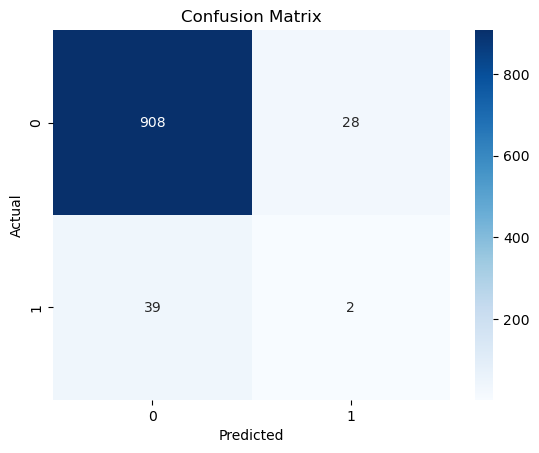


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       936
           1       0.07      0.05      0.06        41

    accuracy                           0.93       977
   macro avg       0.51      0.51      0.51       977
weighted avg       0.92      0.93      0.93       977



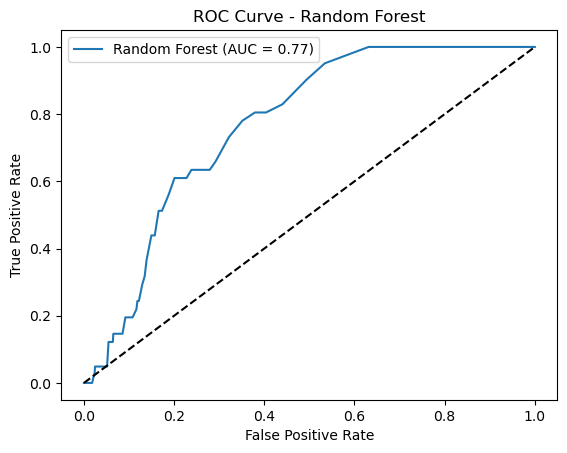

In [ ]:
# Step 9: Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_sample, y_sample)

# Step 10: Evaluate the model
y_pred = rf_model.predict(X_test_prep)
y_proba = rf_model.predict_proba(X_test_prep)[:, 1]

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"AUC Score: {roc_auc_score(y_test, y_proba)}")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

Accuracy: 0.744114636642784
F1 Score: 0.17218543046357615
AUC Score: 0.7803444861371691

Confusion Matrix:


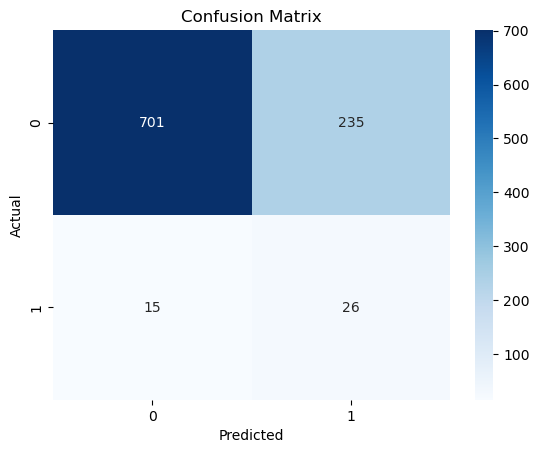


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       936
           1       0.10      0.63      0.17        41

    accuracy                           0.74       977
   macro avg       0.54      0.69      0.51       977
weighted avg       0.94      0.74      0.82       977



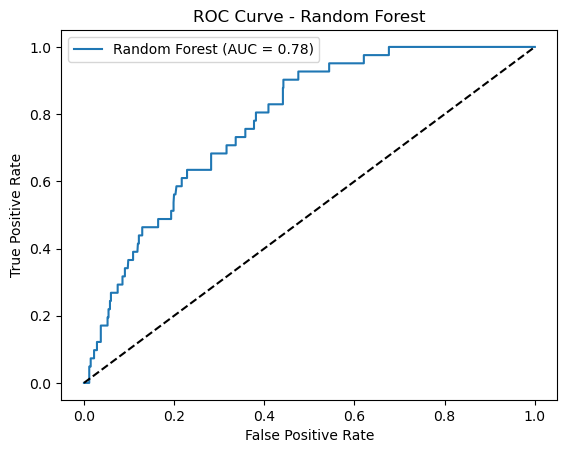

Accuracy: 0.7625383828045036
F1 Score: 0.1773049645390071
AUC Score: 0.797477590160517

Confusion Matrix:


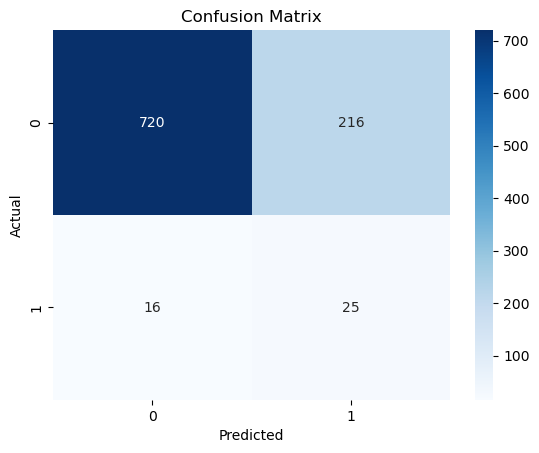


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       936
           1       0.10      0.61      0.18        41

    accuracy                           0.76       977
   macro avg       0.54      0.69      0.52       977
weighted avg       0.94      0.76      0.83       977



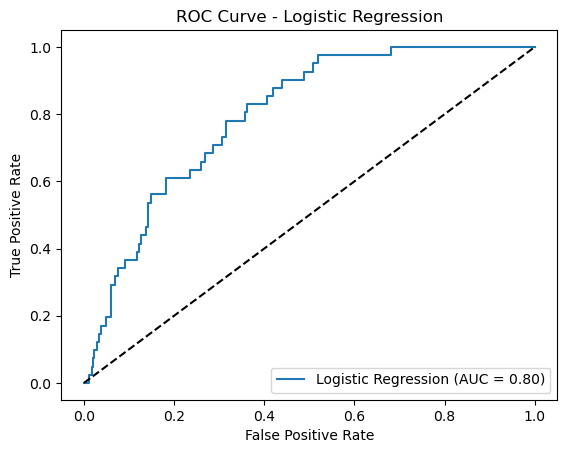

Accuracy: 0.7881269191402251
F1 Score: 0.14107883817427386
AUC Score: 0.711720867208672

Confusion Matrix:


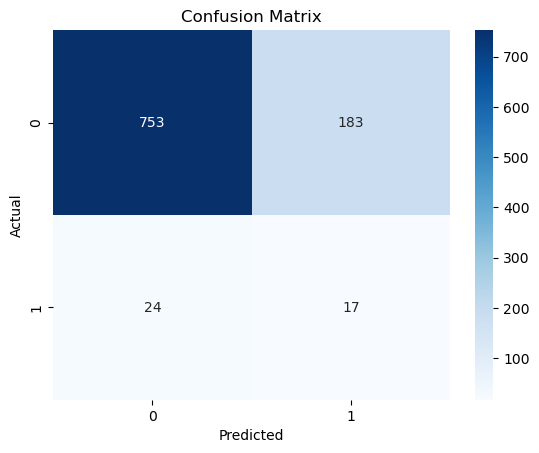


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       936
           1       0.09      0.41      0.14        41

    accuracy                           0.79       977
   macro avg       0.53      0.61      0.51       977
weighted avg       0.93      0.79      0.85       977



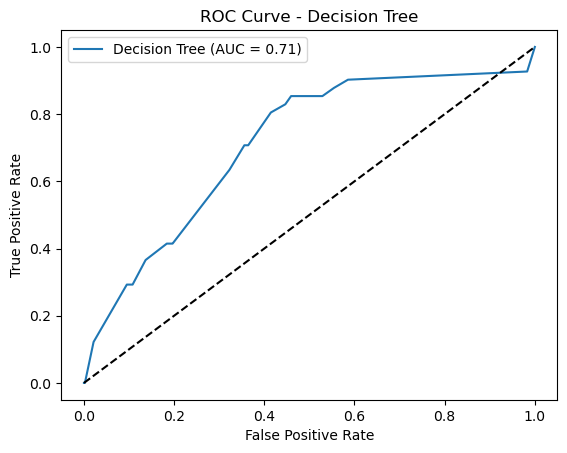

In [ ]:
# Fit on resampled training data
for name, model in models.items():
    model.fit(X_sample, y_sample)

    # Step 10: Evaluate the model
    y_pred = model.predict(X_test_prep)
    y_proba = model.predict_proba(X_test_prep)[:, 1]

    # Print evaluation metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"AUC Score: {roc_auc_score(y_test, y_proba)}")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

In [77]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 12]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='recall')
grid_search.fit(X_sample, y_sample)

best_param = grid_search.best_params_
best_model = grid_search.best_estimator_

print('\033[1mBest Parameters of GridSearchCV for Random Forest Model:\033[0m', best_param)
print("--------------------------------------------------------------------------------------------------------------------")
print('\033[1mBest Estimator of GridSearchCV for Random Forest Model:\033[0m', best_model)

Best Parameters of GridSearchCV for Random Forest Model: {'max_depth': 7, 'min_samples_split': 10}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for Random Forest Model: RandomForestClassifier(max_depth=7, min_samples_split=10, random_state=42)


In [78]:
rf = RandomForestClassifier(**best_param)
rf.fit(X_sample, y_sample)
# Option 1: Evaluate on the training (resampled) set:
y_pred = rf.predict(X_sample)
y_proba = rf.predict_proba(X_sample)[:, 1]

print("Accuracy:", accuracy_score(y_sample, y_pred))
print("F1 Score:", f1_score(y_sample, y_pred))
print("AUC Score:", roc_auc_score(y_sample, y_proba))

# Option 2: Predict and evaluate on the test set (which should not be resampled):
y_pred = rf.predict(X_test_prep)
y_proba = rf.predict_proba(X_test_prep)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

Accuracy: 0.9067592839967941
F1 Score: 0.9115560060821085
AUC Score: 0.9781693483013514
Accuracy: 0.8372569089048106
F1 Score: 0.20100502512562815
AUC Score: 0.774390243902439


              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3743
           1       0.19      0.79      0.31       163

    accuracy                           0.85      3906
   macro avg       0.59      0.82      0.61      3906
weighted avg       0.96      0.85      0.89      3906



<Axes: >

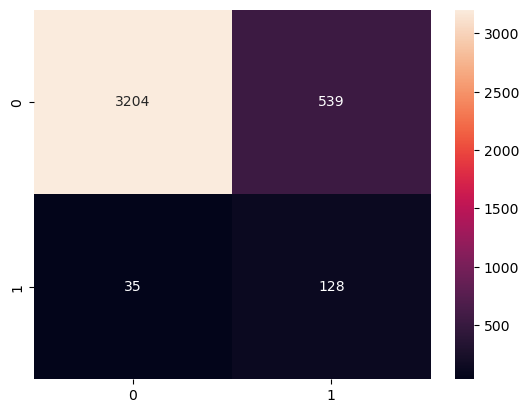

In [81]:
rf = RandomForestClassifier(**best_param)
rf.fit(X_sample, y_sample)

print(classification_report(y_train, rf.predict(X_train_prep), zero_division=0))
sns.heatmap(confusion_matrix(y_train, rf.predict(X_train_prep)), annot=True, fmt='.0f')

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      3743
           1       0.29      0.63      0.40       163

    accuracy                           0.92      3906
   macro avg       0.64      0.78      0.68      3906
weighted avg       0.95      0.92      0.93      3906



<Axes: >

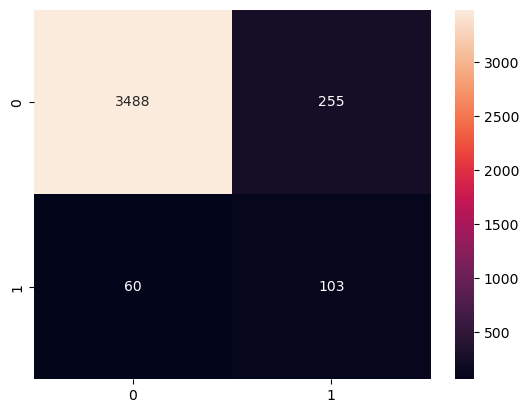

In [82]:
y_pred  = (rf.predict_proba(X_train_prep)[:,1] > 0.6).astype(int)

print(classification_report(y_train, y_pred))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='.0f')

<Axes: >

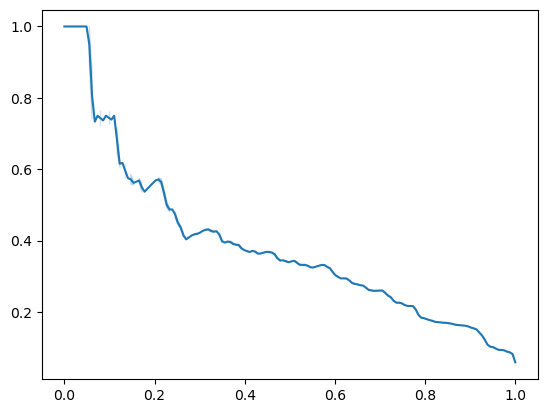

In [83]:
y_score = rf.predict_proba(X_train_prep)[:,1]

precision, recall, thresholds = precision_recall_curve(y_train, y_score)
sns.lineplot(x=recall, y=precision)

In [84]:
rf = RandomForestClassifier(**best_param)
rf.fit(X_train_prep, y_train)

y_pred_train = rf.predict(X_train_prep)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f'RMSE of Train: {rmse_train}')
print(f'R2 of Train: {r2_train}')

y_pred_test = rf.predict(X_test_prep)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'RMSE of Test: {rmse_test}')
print(f'R2 of Test: {r2_test}')

RMSE of Train: 0.20239224690630542
R2 of Train: -0.02434155208331612
RMSE of Test: 0.20485409341915387
R2 of Test: -0.04380341880341909


In [86]:
pd.DataFrame(zip(X_train_prep.columns, rf.feature_importances_), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

,Feature,Importance
0,num__age,0.335624
3,num__avg_glucose_level,0.234635
4,num__bmi,0.158443
1,num__hypertension,0.068370
2,num__heart_disease,0.049176
6,cat__ever_married_Yes,0.027482
9,cat__work_type_Self-employed,0.020533
8,cat__work_type_Private,0.018012
13,cat__smoking_status_never smoked,0.017502
14,cat__smoking_status_smokes,0.017485


### Detailed Modling

In [ ]:
# Function for examining scores

def train_val(y_train, y_train_pred, y_test, y_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

### 1. Implementation of Random Forest Classifier (RF)

**1.a Modelling Random Forest (RF)**

Shape of y_train: (3906,)
Shape of y_train_pred: (7510,)
Shape of y_test: (977,)
Shape of y_pred: (977,)
[[904  20]
 [ 52   1]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       924
           1       0.05      0.02      0.03        53

    accuracy                           0.93       977
   macro avg       0.50      0.50      0.49       977
weighted avg       0.90      0.93      0.91       977

--------------------------------------------------------


,train_set,test_set
Accuracy,1.0,0.926305
Precision,1.0,0.047619
Recall,1.0,0.018868
f1,1.0,0.027027


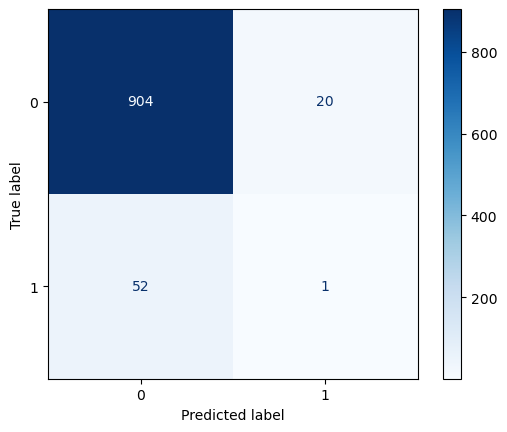

In [ ]:
RF_model = RandomForestClassifier(class_weight="balanced", random_state=42)
RF_model.fit(X_sample, y_sample)
y_pred = RF_model.predict(X_test_prep)
y_train_pred = RF_model.predict(X_sample)

print("Shape of y_train:", y_train.shape)
print("Shape of y_train_pred:", y_train_pred.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred:", y_pred.shape)

rf_f1 = f1_score(y_test, y_pred)
rf_acc = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RF_model.classes_)
disp.plot(cmap=plt.cm.Blues)

train_val(y_sample, y_train_pred, y_test, y_pred)

**1.b Cross-Validating Random Forest (RF)**

In [ ]:
rf_xvalid_model = RandomForestClassifier(max_depth=None, random_state=42)

rf_xvalid_model_scores = cross_validate(rf_xvalid_model, X_sample, y_sample, scoring = ["accuracy", "precision", "recall", "f1"], cv = 5)
rf_xvalid_model_scores = pd.DataFrame(rf_xvalid_model_scores, index = range(1, 6))

rf_xvalid_model_scores

rf_xvalid_model_scores.mean()[2:]

test_accuracy     0.975366
test_precision    0.972046
test_recall       0.978961
test_f1           0.975219
dtype: float64

**1.c Modelling Random Forest (RF) with Best Parameters Using GridSeachCV**

In [ ]:
param_grid = {'n_estimators':[50, 100, 300],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}

RF_grid_model = RandomForestClassifier(random_state=42)

RF_grid_model = GridSearchCV(estimator=RF_grid_model, 
                             param_grid=param_grid, 
                             scoring = "recall", 
                             n_jobs = -1, verbose = 2).fit(X_train, y_train)

print('\033[1mBest Parameters of GridSearchCV for Random Forest Model:\033[0m', RF_grid_model.best_params_)
print("--------------------------------------------------------------------------------------------------------------------")
print('\033[1mBest Estimator of GridSearchCV for Random Forest Model:\033[0m', RF_grid_model.best_estimator_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters of GridSearchCV for Random Forest Model: {'max_depth': 9, 'max_features': 2, 'min_samples_split': 5, 'n_estimators': 100}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for Random Forest Model: RandomForestClassifier(max_depth=9, max_features=2, min_samples_split=5,
                       random_state=42)


[[796 117]
 [ 50 909]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       913
           1       0.89      0.95      0.92       959

    accuracy                           0.91      1872
   macro avg       0.91      0.91      0.91      1872
weighted avg       0.91      0.91      0.91      1872

--------------------------------------------------------


,train_set,test_set
Accuracy,0.933342,0.910791
Precision,0.905974,0.885965
Recall,0.966129,0.947862
f1,0.935085,0.915869


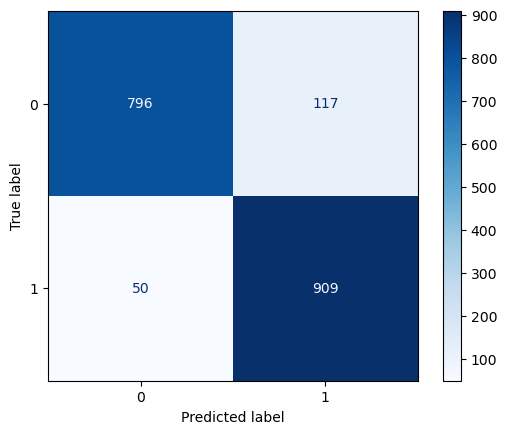

In [ ]:
RF_grid_model = RandomForestClassifier(max_depth=9, max_features=3, n_estimators=50, random_state=42, min_samples_split=2)
RF_grid_model.fit(X_train, y_train)
y_pred = RF_grid_model.predict(X_test)
y_train_pred = RF_grid_model.predict(X_train)

rf_grid_f1 = f1_score(y_test, y_pred)
rf_grid_acc = accuracy_score(y_test, y_pred)
rf_grid_recall = recall_score(y_test, y_pred)
rf_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RF_grid_model.classes_)
disp.plot(cmap=plt.cm.Blues)

train_val(y_train, y_train_pred, y_test, y_pred)

**1.d Feature Importance for Random Forest (RF) Model**

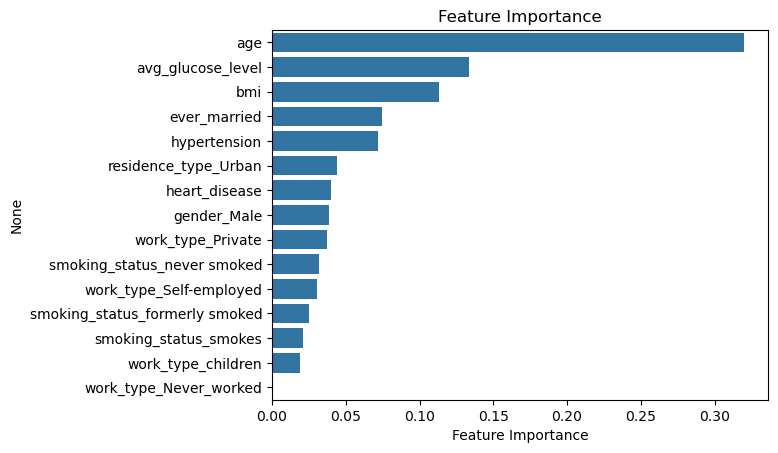

In [ ]:
RF_model.feature_importances_

RF_feature_imp = pd.DataFrame(index = X_train.columns, data = RF_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
RF_feature_imp

sns.barplot(x=RF_feature_imp["Feature Importance"], y=RF_feature_imp.index)
plt.title("Feature Importance")
plt.show()

**1.e ROC (Receiver Operating Curve) and AUC (Area Under Curve)**

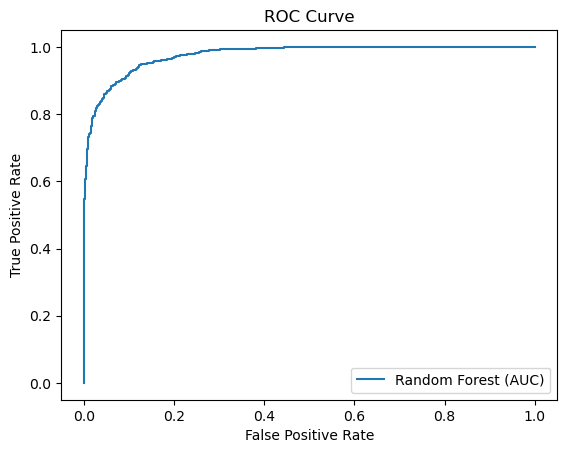

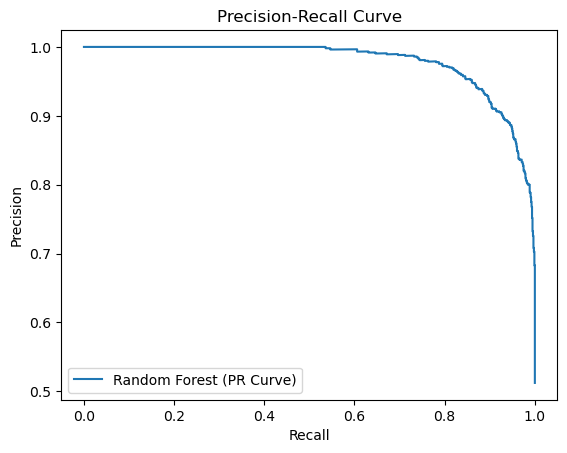

In [ ]:
# Get the predicted probabilities for the positive class (class 1)
y_scores = RF_grid_model.predict_proba(X_test)[:, 1]  # Extract probabilities for class 1

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.plot(fpr, tpr, label="Random Forest (AUC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, label="Random Forest (PR Curve)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

### 2. Implementation of Support Vector Machine (SVM)

**2.a Modelling Support Vector Machine (SVM) with Default Parameters**

[[750 163]
 [ 55 904]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       913
           1       0.85      0.94      0.89       959

    accuracy                           0.88      1872
   macro avg       0.89      0.88      0.88      1872
weighted avg       0.89      0.88      0.88      1872



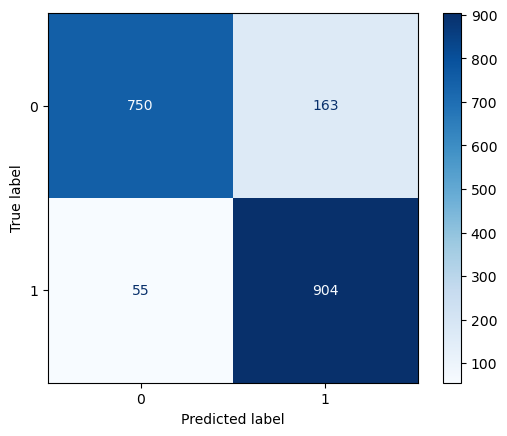

In [74]:
svm_model = SVC(class_weight = "balanced")
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)

**2.b Cross-Validating Support Vector Machine(SVM)**

In [75]:
svm_xvalid_model = SVC()

svm_xvalid_model_scores = cross_validate(svm_xvalid_model, X_train, y_train, scoring = ['accuracy', 'precision','recall', 'f1'], cv = 5)
svm_xvalid_model_scores = pd.DataFrame(svm_xvalid_model_scores, index = range(1, 6))

svm_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,1.430704,0.570208,0.903204,0.866585,0.951613,0.907111
2,1.294615,0.607912,0.874415,0.836562,0.928763,0.880255
3,1.315037,0.537589,0.868403,0.819137,0.943548,0.876952
4,1.352766,0.578948,0.879760,0.830211,0.952957,0.887359
5,1.368519,0.551177,0.879760,0.845588,0.927419,0.884615


In [76]:
model = SVC(class_weight = "balanced")

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 5)
df_scores = pd.DataFrame(scores, index = range(1, 6))
df_scores.mean()[2:]

test_accuracy     0.881643
test_precision    0.839284
test_recall       0.942742
test_f1           0.887911
dtype: float64

**2.c Modelling Support Vector Machine (SVM) with Best Parameters Using GridSeachCV**

In [23]:
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'linear']}

model = SVC(class_weight = "balanced")
svm_model_grid = GridSearchCV(model, param_grid, verbose=3, refit=True)

svm_model_grid.fit(X_train, y_train)

print('\033[1mBest Parameters of GridSearchCV for SVM Model:\033[0m', svm_model_grid.best_params_)
print("--------------------------------------------------------------------------------------------------------------------")
print('\033[1mBest Estimator of GridSearchCV for SVM Model:\033[0m', svm_model_grid.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.804 total time=   4.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.804 total time=   4.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.774 total time=   3.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.784 total time=   4.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.783 total time=   4.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.802 total time=   1.3s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.796 total time=   1.3s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.783 total time=   1.2s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.802 total time=   1.3s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.794 total time=   1.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.889 total time=   2.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

-----------CONFUSION MATRIX------------
[[856  57]
 [ 38 921]]
--------------------------------------------------------
-----------CLASSIFICATION REPORT---------
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       913
           1       0.94      0.96      0.95       959

    accuracy                           0.95      1872
   macro avg       0.95      0.95      0.95      1872
weighted avg       0.95      0.95      0.95      1872

--------------------------------------------------------


,train_set,test_set
Accuracy,0.993321,0.949252
Precision,0.991957,0.941718
Recall,0.994624,0.960375
f1,0.993289,0.950955


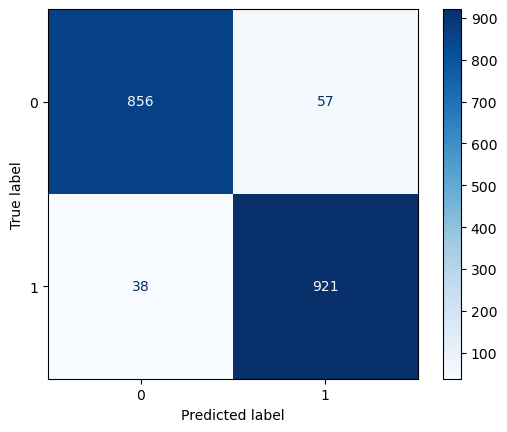

In [40]:
svm_grid_model = SVC(C=10, class_weight='balanced', gamma=1, kernel='rbf')
svm_grid_model.fit(X_train, y_train)
y_pred =svm_grid_model.predict(X_test)
y_train_pred = svm_grid_model.predict(X_train)

svm_grid_f1 = f1_score(y_test, y_pred)
svm_grid_acc = accuracy_score(y_test, y_pred)
svm_grid_recall = recall_score(y_test, y_pred)
svm_grid_auc = roc_auc_score(y_test, y_pred)

print('-----------CONFUSION MATRIX------------')
print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print('-----------CLASSIFICATION REPORT---------')
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_grid_model.classes_)
disp.plot(cmap=plt.cm.Blues)

train_val(y_train, y_train_pred, y_test, y_pred)

**2.d ROC (Receiver Operating Curve) and AUC (Area Under Curve)**

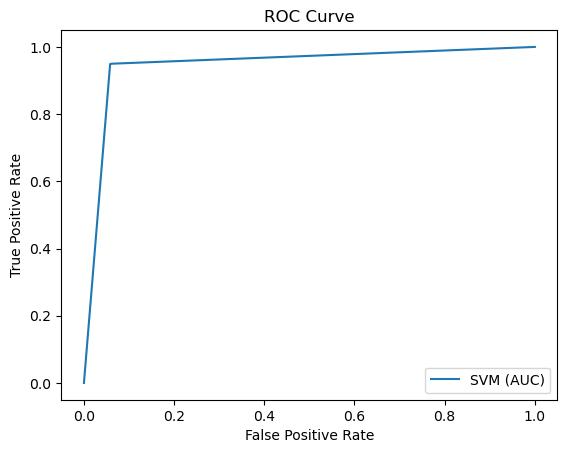

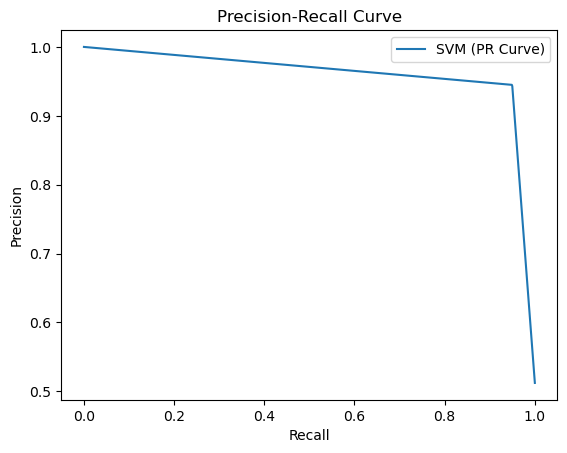

In [41]:
# Get decision scores (raw outputs from the SVM decision function)
decision_scores = svm_grid_model.decision_function(X_test)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, decision_scores)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.plot(fpr, tpr, label="SVM (AUC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, label="SVM (PR Curve)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

### 3. Implementation of Decision Tree (DT) 

**3.a Modelling Decision Tree (DT) with Default Parameters**

[[838  75]
 [ 59 900]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       913
           1       0.92      0.94      0.93       959

    accuracy                           0.93      1872
   macro avg       0.93      0.93      0.93      1872
weighted avg       0.93      0.93      0.93      1872

--------------------------------------------------------


,train_set,test_set
Accuracy,1.0,0.928419
Precision,1.0,0.923077
Recall,1.0,0.938478
f1,1.0,0.930714


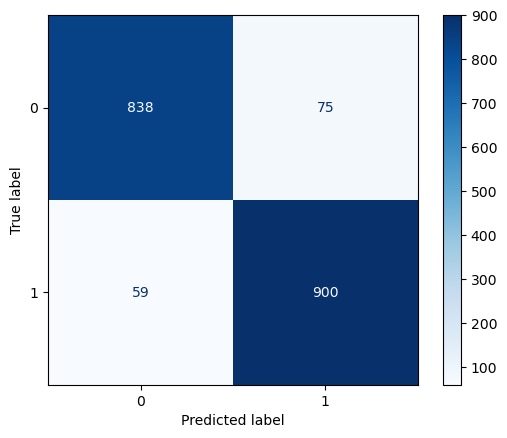

In [77]:
DT_model = DecisionTreeClassifier(class_weight="balanced", random_state=42)
DT_model.fit(X_train, y_train)
y_pred = DT_model.predict(X_test)
y_train_pred = DT_model.predict(X_train)

dt_f1 = f1_score(y_test, y_pred)
dt_acc = accuracy_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DT_model.classes_)
disp.plot(cmap=plt.cm.Blues)

train_val(y_train, y_train_pred, y_test, y_pred)

**3.b Cross-Validating Decision Tree (DT)**

In [78]:
dt_xvalid_model = DecisionTreeClassifier(max_depth=None, random_state=42)

dt_xvalid_model_scores = cross_validate(dt_xvalid_model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 5)
dt_xvalid_model_scores = pd.DataFrame(dt_xvalid_model_scores, index = range(1, 6))

dt_xvalid_model_scores

dt_xvalid_model_scores.mean()[2:]

test_accuracy     0.917312
test_precision    0.907070
test_recall       0.928763
test_f1           0.917762
dtype: float64

**3.c Modelling Decision Tree (DT) with Best Parameters Using RandomizedsearchCV**

In [79]:
parameters={'max_depth':(10,20,30,40,50),'criterion':('gini','entropy'),'max_features':('log2','sqrt','auto'),
            'min_samples_split':(2,4,6),'random_state':(0,1,2,3,4,5)}

DT_hp=RandomizedSearchCV(tree.DecisionTreeClassifier(),param_distributions=parameters,cv=5,random_state=2)

DT_fit=DT_hp.fit(X_train,y_train)

print('\033[1mBest Parameters of RandomizedSearchCV for Decision Tree Model:\033[0m', DT_hp.best_params_)
print("--------------------------------------------------------------------------------------------------------------------")
print('\033[1mBest Estimator of RandomizedSearchCV for Decision Tree Model:\033[0m', DT_hp.best_estimator_)

Best Parameters of RandomizedSearchCV for Decision Tree Model: {'random_state': 5, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of RandomizedSearchCV for Decision Tree Model: DecisionTreeClassifier(max_depth=20, max_features='sqrt', random_state=5)


-----------CONFUSION MATRIX------------
[[854  59]
 [ 58 901]]
--------------------------------------------------------
-----------CLASSIFICATION REPORT---------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       913
           1       0.94      0.94      0.94       959

    accuracy                           0.94      1872
   macro avg       0.94      0.94      0.94      1872
weighted avg       0.94      0.94      0.94      1872

--------------------------------------------------------
--------------Plot for Confusion_matrix------------
---------------Train vs Test Report----------------


,train_set,test_set
Accuracy,0.995993,0.937500
Precision,0.994108,0.938542
Recall,0.997849,0.939520
f1,0.995975,0.939031


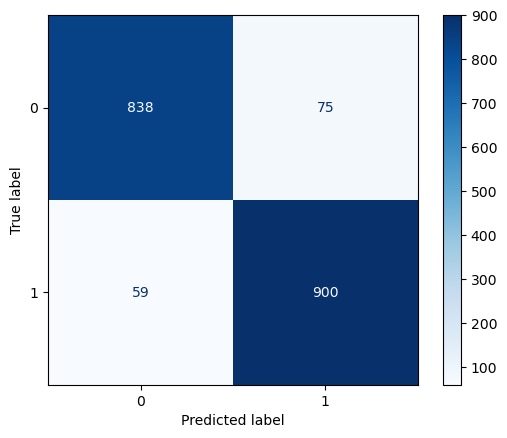

In [80]:
model_after_ht=tree.DecisionTreeClassifier(criterion='gini', max_depth=20, max_features='sqrt', min_samples_split=2, random_state=5)
model_ht=model_after_ht.fit(X_train,y_train)

y_pred_DT =model_ht.predict(X_test)
y_train_pred_DT = model_ht.predict(X_train)

DT_grid_f1 = f1_score(y_test, y_pred_DT)
DT_grid_acc = accuracy_score(y_test, y_pred_DT)
DT_grid_recall = recall_score(y_test, y_pred_DT)
DT_grid_auc = roc_auc_score(y_test, y_pred_DT)

print('-----------CONFUSION MATRIX------------')
print(confusion_matrix(y_test, y_pred_DT))
print("\033[1m--------------------------------------------------------\033[0m")
print('-----------CLASSIFICATION REPORT---------')
print(classification_report(y_test, y_pred_DT))
print("\033[1m--------------------------------------------------------\033[0m")

print('--------------Plot for Confusion_matrix------------')
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_ht.classes_)
disp.plot(cmap=plt.cm.Blues)

print('---------------Train vs Test Report----------------')
train_val(y_train, y_train_pred_DT, y_test, y_pred_DT)

**3.d Feature Importance for Decision Tree (DT) Model**

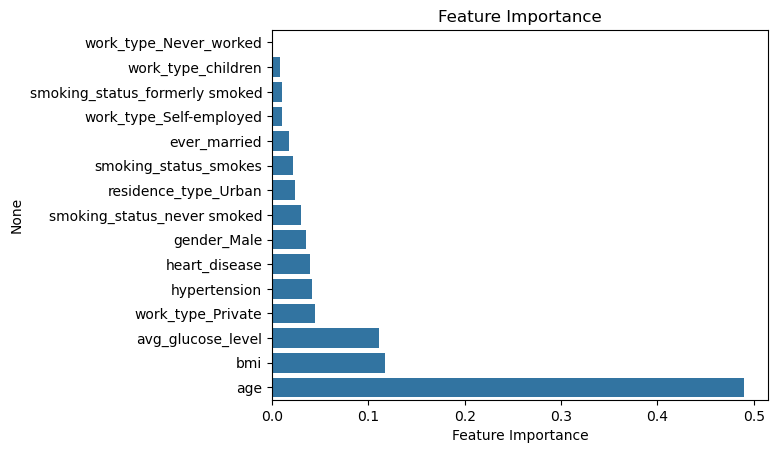

In [81]:
model_ht.feature_importances_

DT_feature_imp = pd.DataFrame(index=X_train.columns, data = DT_model.feature_importances_, columns = ["Feature Importance"]).sort_values("Feature Importance")
DT_feature_imp

sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

**3.e ROC (Receiver Operating Curve) and AUC (Area Under Curve)**

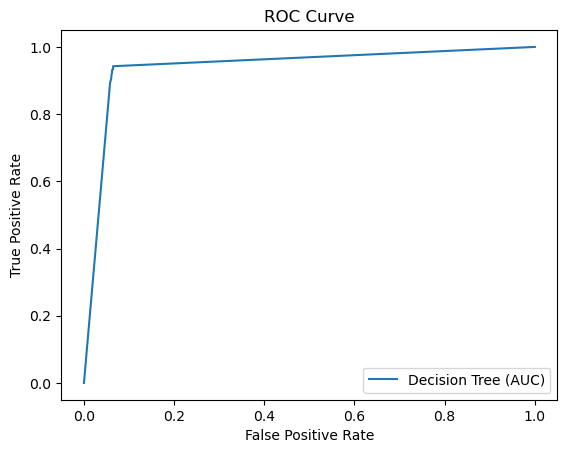

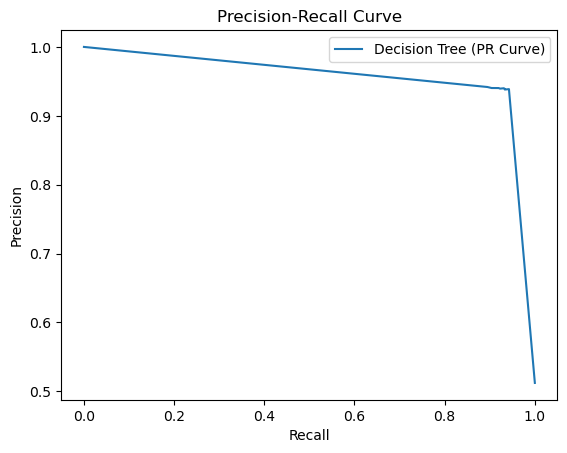

In [82]:
# Get the predicted probabilities for the positive class (class 1)
y_scores = model_ht.predict_proba(X_test)[:, 1]  # Extract probabilities for class 1

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.plot(fpr, tpr, label="Decision Tree (AUC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, label="Decision Tree (PR Curve)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

### 4. The Implementation of K-Nearest Neighbor (KNN)

**4.a Modelling K-Nearest Neighbor (KNN) with Default Parameters**

[[758 155]
 [  3 956]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       913
           1       0.86      1.00      0.92       959

    accuracy                           0.92      1872
   macro avg       0.93      0.91      0.91      1872
weighted avg       0.93      0.92      0.91      1872

--------------------------------------------------------


,train_set,test_set
Accuracy,0.942025,0.915598
Precision,0.896477,0.860486
Recall,0.998656,0.996872
f1,0.944812,0.923671


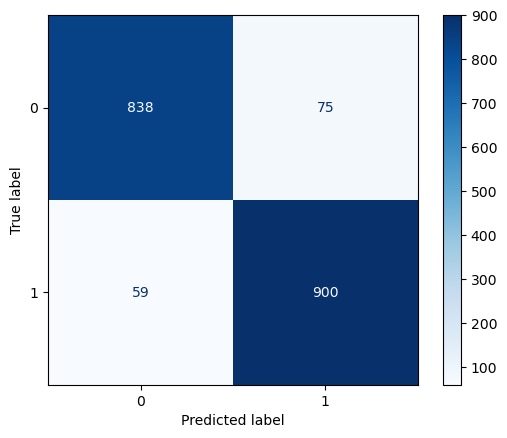

In [83]:
KNN_model = KNeighborsClassifier(n_neighbors=5,p=2,metric='euclidean')
KNN_model.fit(X_train, y_train)
y_pred_KNN = KNN_model.predict(X_test)
y_train_pred_KNN = KNN_model.predict(X_train)

knn_f1 = f1_score(y_test, y_pred_KNN)
knn_acc = accuracy_score(y_test, y_pred_KNN)
knn_recall = recall_score(y_test, y_pred_KNN)
knn_auc = roc_auc_score(y_test, y_pred_KNN)

print(confusion_matrix(y_test, y_pred_KNN))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred_KNN))
print("\033[1m--------------------------------------------------------\033[0m")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=KNN_model.classes_)
disp.plot(cmap=plt.cm.Blues)

train_val(y_train, y_train_pred_KNN, y_test, y_pred_KNN)

**4.b Cross-Validating K-Nearest Neighbor (KNN)**

In [84]:
knn_xvalid_model = KNeighborsClassifier(n_neighbors=5)

knn_xvalid_model_scores = cross_validate(knn_xvalid_model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 5)
knn_xvalid_model_scores = pd.DataFrame(knn_xvalid_model_scores, index = range(1, 6))

knn_xvalid_model_scores

knn_xvalid_model_scores.mean()[2:]

test_accuracy     0.912769
test_precision    0.853456
test_recall       0.995699
test_f1           0.919056
dtype: float64

**4.c Elbow Method for Choosing Reasonable K Values**

Text(0, 0.5, 'Error_rate')

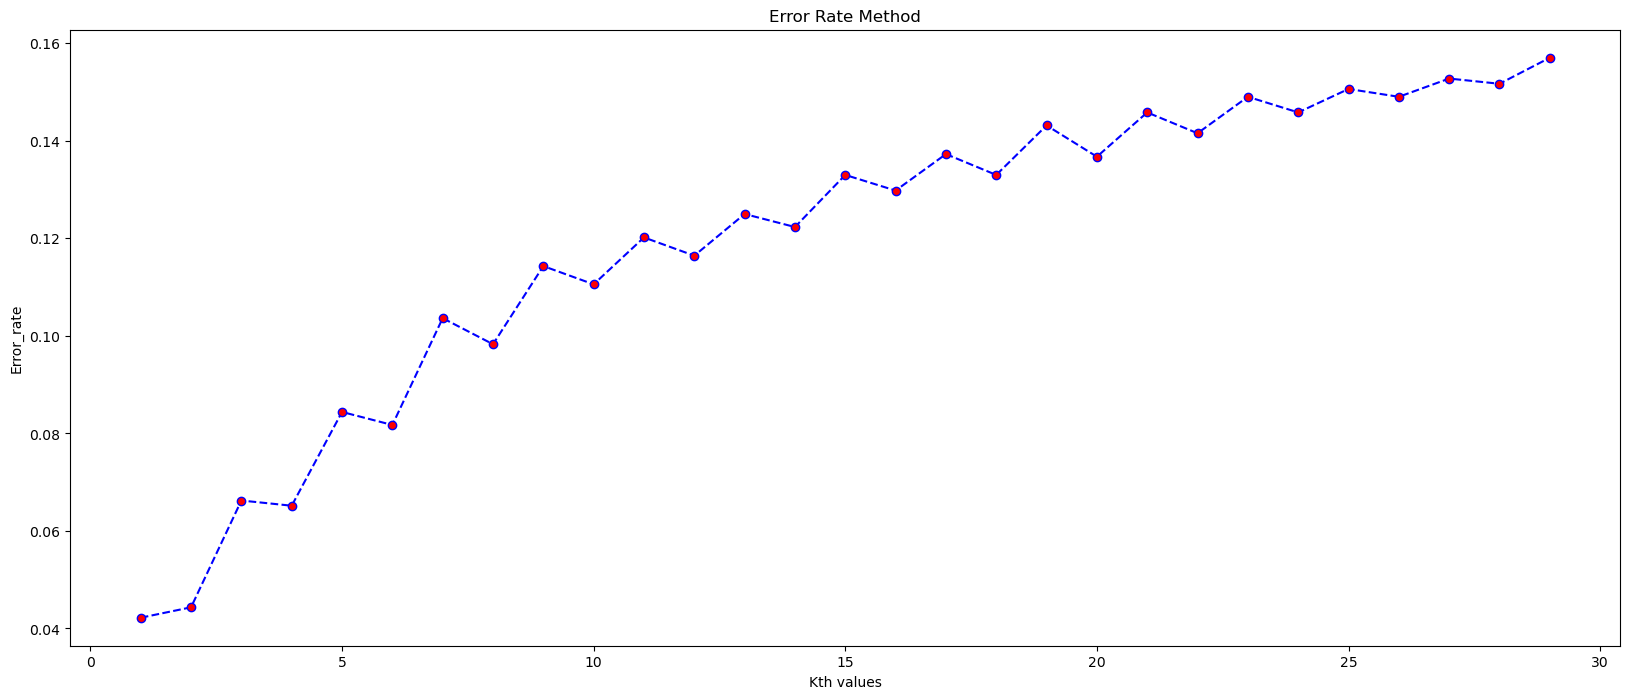

In [85]:
test_error_rates = []

for k in range(1, 30):
    KNN_model = KNeighborsClassifier(n_neighbors=k)
    KNN_model.fit(X_train, y_train) 
   
    y_pred_Er = KNN_model.predict(X_test)
    test_error_rates.append(np.mean(y_pred_Er!=y_test))

plt.figure(figsize=(20,8))
plt.plot(range(1,30),test_error_rates,color='blue',linestyle='dashed',marker='o',markerfacecolor='red')
plt.title("Error Rate Method")
plt.xlabel('Kth values')
plt.ylabel('Error_rate')

**4.d GridsearchCV for Choosing Reasonable K Values**

In [86]:
k_values= range(1, 30)
param_grid = {"n_neighbors": k_values, "p": [1, 2], "weights": ['uniform', "distance"]}

KNN_grid = KNeighborsClassifier()
KNN_grid_model = GridSearchCV(KNN_grid, param_grid, cv=5, scoring='accuracy')
KNN_grid_model.fit(X_train, y_train)

print('\033[1mBest Parameters of GridSearchCV for KNN Model:\033[0m', KNN_grid_model.best_params_)
print("--------------------------------------------------------------------------------------------------------------------")
print('\033[1mBest Estimator of GridSearchCV for KNN Model:\033[0m', KNN_grid_model.best_estimator_)

Best Parameters of GridSearchCV for KNN Model: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for KNN Model: KNeighborsClassifier(n_neighbors=1, p=1)


WITH K=1
-------------------
[[855  58]
 [ 11 948]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       913
           1       0.94      0.99      0.96       959

    accuracy                           0.96      1872
   macro avg       0.96      0.96      0.96      1872
weighted avg       0.96      0.96      0.96      1872

--------------------------------------------------------


,train_set,test_set
Accuracy,1.0,0.963141
Precision,1.0,0.942346
Recall,1.0,0.988530
f1,1.0,0.964885


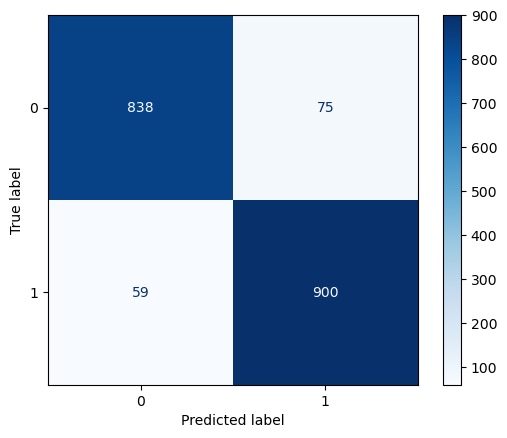

In [87]:
# NOW WITH K=1
KNN_model = KNeighborsClassifier(n_neighbors=1, p=1, weights='uniform')
KNN_model.fit(X_train, y_train)
y_pred_ER = KNN_model.predict(X_test)
y_train_pred_ER = KNN_model.predict(X_train)

knn26_f1 = f1_score(y_test, y_pred_ER)
knn26_acc = accuracy_score(y_test, y_pred_ER)
knn26_recall = recall_score(y_test, y_pred_ER)
knn26_auc = roc_auc_score(y_test, y_pred_ER)

print('WITH K=1')
print('-------------------')
print(confusion_matrix(y_test,y_pred_ER))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test,y_pred_ER))
print("\033[1m--------------------------------------------------------\033[0m")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=KNN_model.classes_)
disp.plot(cmap=plt.cm.Blues)

train_val(y_train, y_train_pred_ER, y_test, y_pred_ER)

**4.e ROC (Receiver Operating Curve) and AUC (Area Under Curve)**

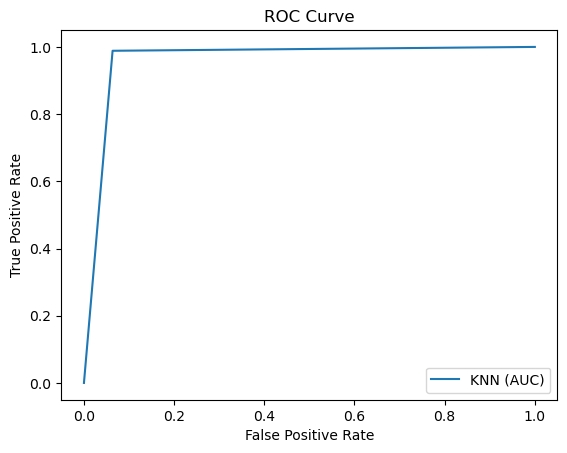

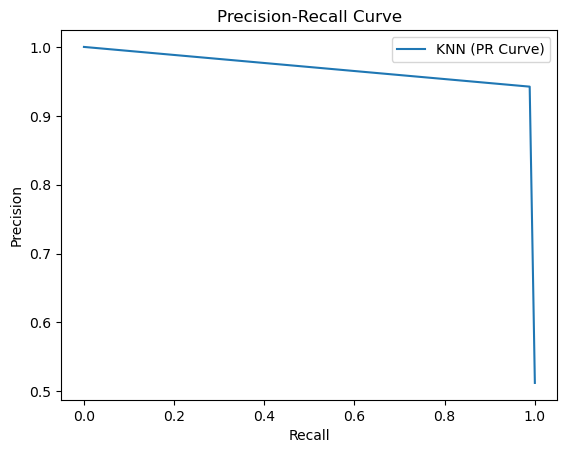

In [88]:
# Get the predicted probabilities for the positive class (class 1)
y_scores = KNN_model.predict_proba(X_test)[:, 1]  # Extract probabilities for class 1

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.plot(fpr, tpr, label="KNN (AUC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, label="KNN (PR Curve)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

### 5. Implementation of Logistic Regression (lg)

**5.a Modelling Logistic Regression (lg)**

[[679 234]
 [170 789]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       913
           1       0.77      0.82      0.80       959

    accuracy                           0.78      1872
   macro avg       0.79      0.78      0.78      1872
weighted avg       0.79      0.78      0.78      1872

--------------------------------------------------------


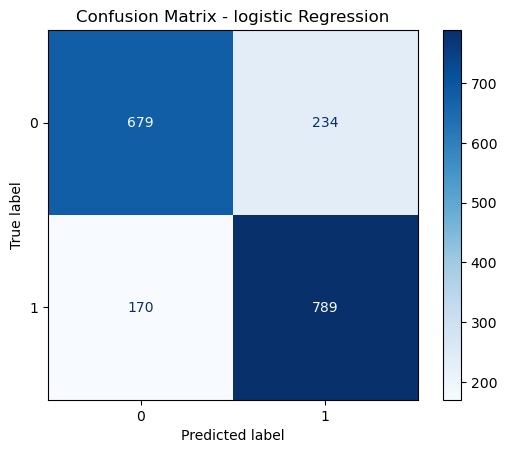

In [89]:
# Initialize and train the model
lg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lg.fit(X_train, y_train)

# Predictions
lg_y_pred = lg.predict(X_test)
lg_y_train_pred = lg.predict(X_train)

# Evaluation metrics
lg_f1 = f1_score(y_test, lg_y_pred)
lg_acc = accuracy_score(y_test, lg_y_pred)
lg_recall = recall_score(y_test, lg_y_pred)
lg_auc = roc_auc_score(y_test, lg_y_pred)

# Print metrics
print(confusion_matrix(y_test, lg_y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, lg_y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

# Confusion matrix plot
lg_cm = confusion_matrix(y_test, lg_y_pred)
lg_disp = ConfusionMatrixDisplay(confusion_matrix=lg_cm, display_labels=lg.classes_)
lg_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - logistic Regression")
plt.show()

**5.b Cross-Validating Logistic Regression (lg)**

In [90]:
# Initialize the model
lg_xvalid_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Perform 5-fold cross-validation with desired metrics
lg_xvalid_model_scores = cross_validate(
    lg_xvalid_model, 
    X_train, 
    y_train, 
    scoring=["accuracy", "precision", "recall", "f1"], 
    cv=5
)

# Convert results to DataFrame for easy readability
lg_xvalid_model_scores = pd.DataFrame(lg_xvalid_model_scores, index=range(1, 6))

# Display the mean of the metric columns only
print(lg_xvalid_model_scores)
print("\nAverage Scores:")
print(lg_xvalid_model_scores.mean()[2:])

   fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1
1  0.039257    0.029055       0.797063        0.774314     0.834677  0.803364
2  0.030290    0.019069       0.783567        0.765152     0.814516  0.789062
3  0.034327    0.024366       0.768871        0.741505     0.821237  0.779337
4  0.036341    0.026657       0.792251        0.768944     0.831989  0.799225
5  0.037355    0.018712       0.787575        0.762315     0.831989  0.795630

Average Scores:
test_accuracy     0.785865
test_precision    0.762446
test_recall       0.826882
test_f1           0.793324
dtype: float64


**5.c Modelling Logistic Regression (lg) with Best Parameters Using GridSeachCV**

In [91]:
# Define parameter grid for Logistic Regression
lg_param_grid = {
    'penalty': ['l2', None],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga', 'liblinear'],
    'max_iter': [100, 200, 500]
}

# Initialize base model
lg_grid_model = LogisticRegression(class_weight='balanced', random_state=42)

# Run GridSearchCV
lg_grid_model = GridSearchCV(
    estimator=lg_grid_model,
    param_grid=lg_param_grid,
    scoring='recall',
    n_jobs=-1,
    verbose=2
).fit(X_train, y_train)

# Print results
print('\033[1mBest Parameters of GridSearchCV for Logistic Regression Model:\033[0m', lg_grid_model.best_params_)
print("--------------------------------------------------------------------------------------------------------------------")
print('\033[1mBest Estimator of GridSearchCV for Logistic Regression Model:\033[0m', lg_grid_model.best_estimator_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters of GridSearchCV for Logistic Regression Model: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for Logistic Regression Model: LogisticRegression(C=0.01, class_weight='balanced', random_state=42,
                   solver='liblinear')


[[656 257]
 [148 811]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.72      0.76       913
           1       0.76      0.85      0.80       959

    accuracy                           0.78      1872
   macro avg       0.79      0.78      0.78      1872
weighted avg       0.79      0.78      0.78      1872

--------------------------------------------------------


,train_set,test_set
Accuracy,0.784665,0.783654
Precision,0.753244,0.759363
Recall,0.842742,0.845673
f1,0.795483,0.800197


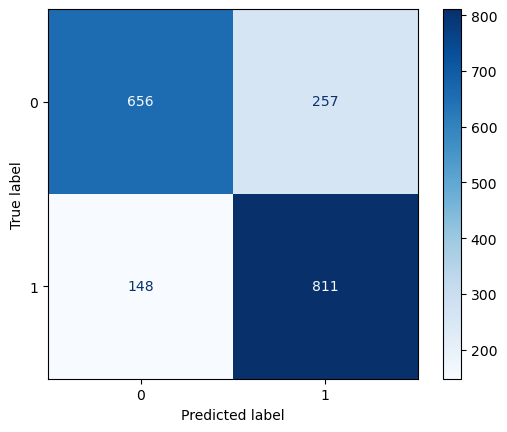

In [92]:
lg_grid_model = LogisticRegression(C=0.01, class_weight='balanced', random_state=42, solver='liblinear', max_iter = 100, penalty = 'l2')
lg_grid_model.fit(X_train, y_train)
y_pred = lg_grid_model.predict(X_test)
y_train_pred = lg_grid_model.predict(X_train)

lg_grid_f1 = f1_score(y_test, y_pred)
lg_grid_acc = accuracy_score(y_test, y_pred)
lg_grid_recall = recall_score(y_test, y_pred)
lg_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lg_grid_model.classes_)
disp.plot(cmap=plt.cm.Blues)

train_val(y_train, y_train_pred, y_test, y_pred)

**5.d Feature Importance for Logistic Regression (lg) Model**

                                Feature Importance
age                                       2.004848
work_type_children                        1.299272
hypertension                              0.574217
smoking_status_smokes                     0.565857
work_type_Private                         0.368925
smoking_status_formerly smoked            0.306563
avg_glucose_level                         0.212598
ever_married                              0.196035
heart_disease                             0.011421
bmi                                       0.006369
smoking_status_never smoked              -0.016675
residence_type_Urban                     -0.022469
work_type_Never_worked                   -0.072977
gender_Male                              -0.181554
work_type_Self-employed                  -0.266884


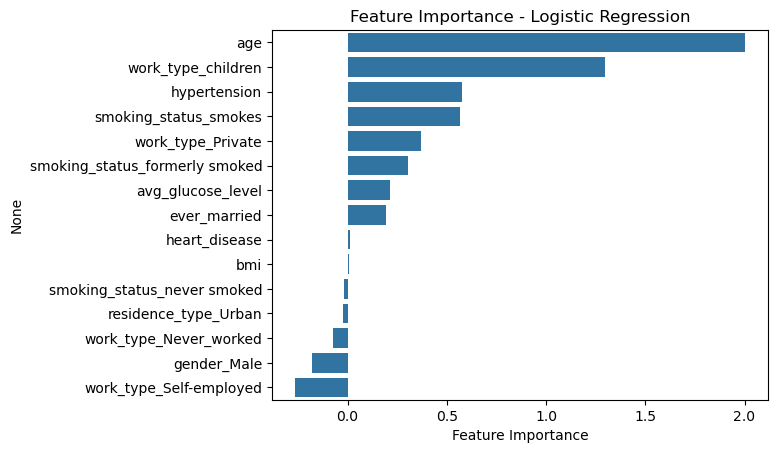

In [94]:
# Get feature coefficients from the Logistic Regression model
lg_feature_imp = pd.DataFrame(
    data=lg.coef_[0],  # Extract the coefficients (1D array)
    index=X_train.columns,  # Use the feature names as the index
    columns=["Feature Importance"]
).sort_values("Feature Importance", ascending=False)

# Display the feature importance DataFrame
print(lg_feature_imp)

# Create a bar plot for feature importance
sns.barplot(x=lg_feature_imp["Feature Importance"], y=lg_feature_imp.index)
plt.title("Feature Importance - Logistic Regression")
plt.show()

**5.e ROC (Receiver Operating Curve) and AUC (Area Under Curve)**

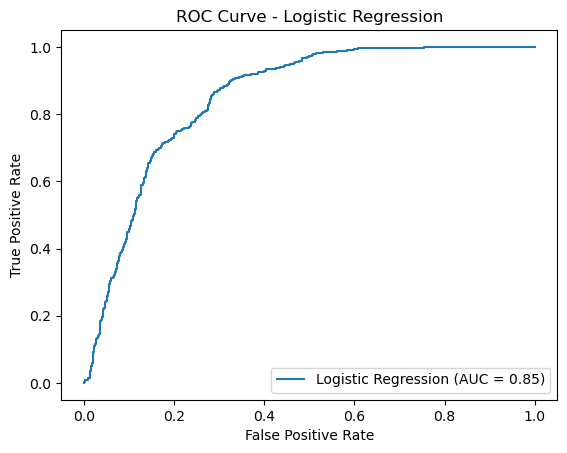

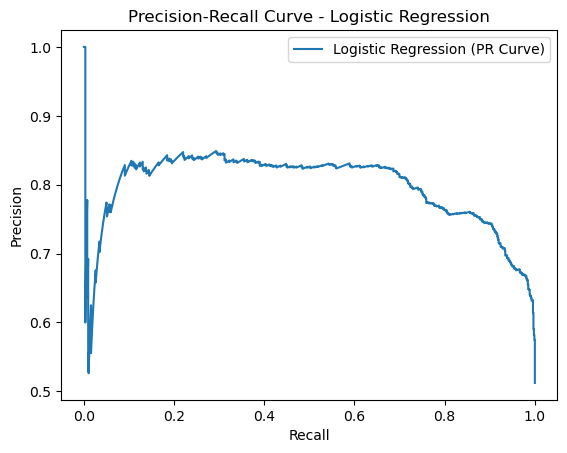

In [95]:
# Get the predicted probabilities for the positive class (class 1)
y_scores_lg = lg_grid_model.predict_proba(X_test)[:, 1]  # Extract probabilities for class 1

# Compute the ROC curve
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_scores_lg)

# Plot the ROC curve
plt.plot(fpr_lg, tpr_lg, label="Logistic Regression (AUC = %0.2f)" % roc_auc_score(y_test, y_scores_lg))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

# Calculate precision, recall, and thresholds for Precision-Recall Curve
precision_lg, recall_lg, thresholds_pr_lg = precision_recall_curve(y_test, y_scores_lg)

# Plot the Precision-Recall curve
plt.plot(recall_lg, precision_lg, label="Logistic Regression (PR Curve)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.show()

## THE COMPARISON OF MODELS

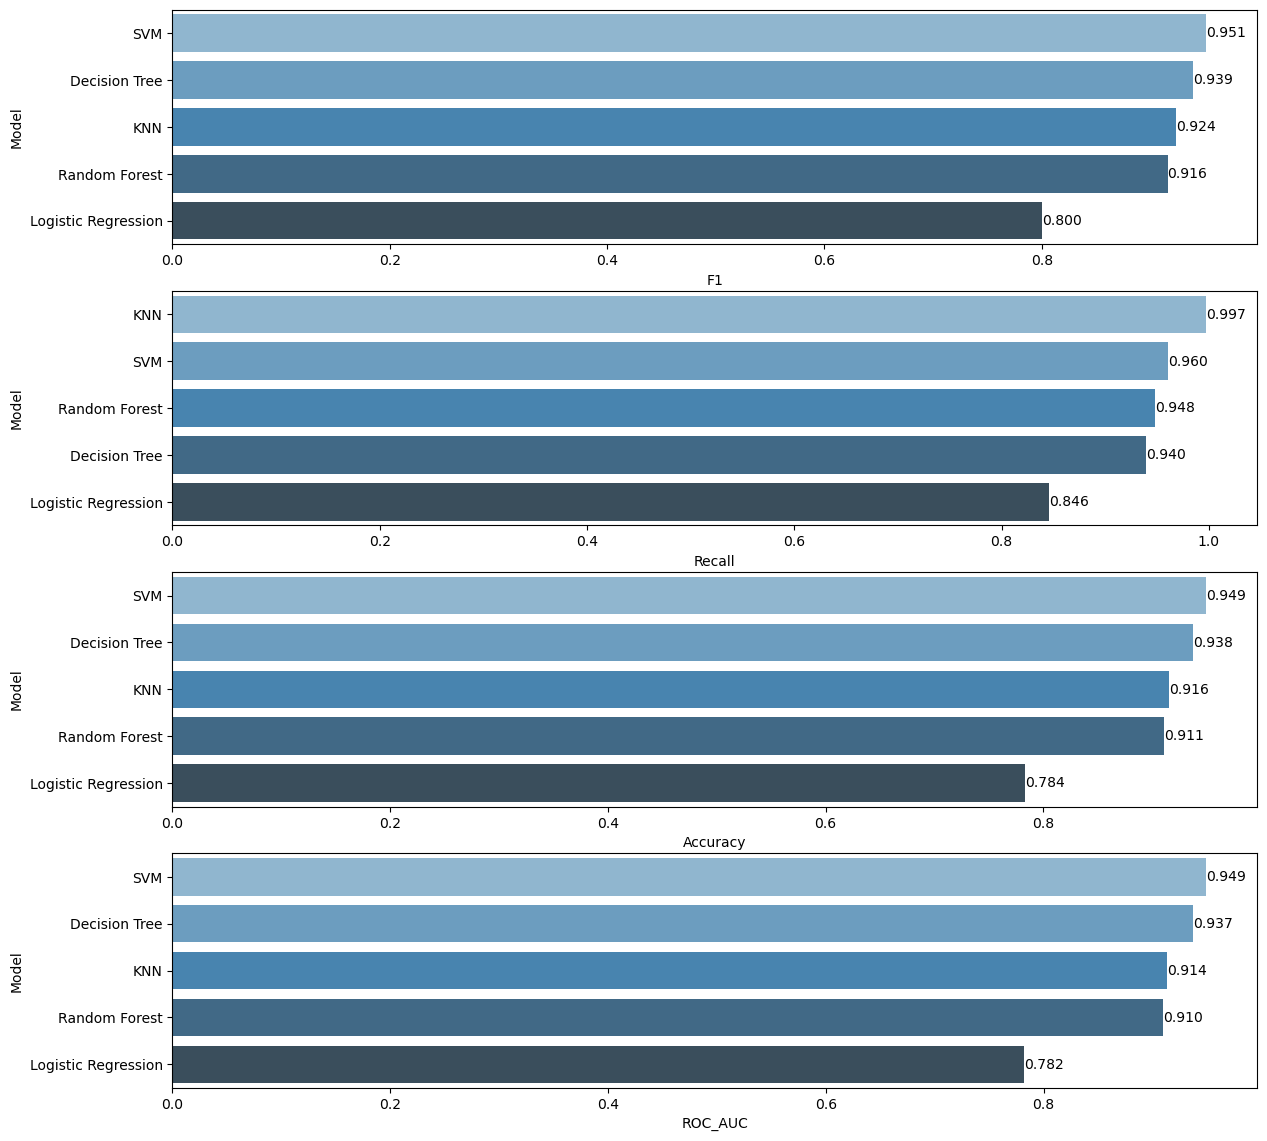

In [96]:
compare = pd.DataFrame({"Model": [ "SVM", "KNN", "Decision Tree", "Random Forest", "Logistic Regression"],
                        "F1": [ svm_grid_f1, knn_f1, DT_grid_f1, rf_grid_f1, lg_grid_f1],
                        "Recall": [ svm_grid_recall, knn_recall, DT_grid_recall, rf_grid_recall, lg_grid_recall],
                        "Accuracy": [ svm_grid_acc, knn_acc, DT_grid_acc, rf_grid_acc, lg_grid_acc],
                        "ROC_AUC": [ svm_grid_auc, knn_auc, DT_grid_auc, rf_grid_auc, lg_grid_auc]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,14))
plt.subplot(411)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(412)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(413)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(414)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax=sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.show()

## CONCLUSION

**In this Project Respectively,  We have tried to a predict classification problem in Stroke Dataset by a variety of models to classify Stroke predictions in the context of determining whether anybody is likely to get Stroke based on the input parameters like gender, age and various test results or not  We have made the detailed exploratory analysis (EDA). missing values are removed in the Dataset by using Simple Imputer with Median We have decided which metrics will be used. We have analysed both target and features in detail. We have transformed categorical variables into integer by using Label Encoder, so we can use them in the models. We have examined the feature importance of some models.Lastly we have examined the results of all models visually with respect to select the best one for the problem in hand. By checking with all the scores like F1_score, Precision, Recall and Accuracy, The *Random Forest* gives the best results while comparing with other models. For Respective Dataset the *Random Forest* is the Best model for Future Predictions.**

# Prepare for Deployment

In [92]:
import pickle

In [87]:
# Step 11: Save the pipeline (for deployment)
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

In [106]:
# Assume you have already fitted the pipeline
model_pipeline.fit(X_train, y_train)

# Access the ColumnTransformer inside the pipeline
preprocessor = model_pipeline.named_steps['preprocessor']

# Get feature names after transformation
feature_names = preprocessor.get_feature_names_out()

print(feature_names)

['num__age' 'num__hypertension' 'num__heart_disease'
 'num__avg_glucose_level' 'num__bmi' 'cat__gender_Male'
 'cat__ever_married_Yes' 'cat__work_type_Never_worked'
 'cat__work_type_Private' 'cat__work_type_Self-employed'
 'cat__work_type_children' 'cat__residence_type_Urban'
 'cat__smoking_status_formerly smoked' 'cat__smoking_status_never smoked'
 'cat__smoking_status_smokes']


In [ ]:
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(model_pipeline, f)

In [ ]:
# --- Deployment Prediction Example ---
def predict(features):
    # Ensure the input is a pandas DataFrame
    if not isinstance(features, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")
    
    # Check for missing columns
    expected_columns = X_train.columns  # Assuming X_train is your training data
    missing_cols = set(expected_columns) - set(features.columns)
    if missing_cols:
        raise ValueError(f"Missing columns: {missing_cols}")
    
    # Ensure correct data types
    for col in expected_columns:
        if features[col].dtype != X_train[col].dtype:
            raise TypeError(f"Column '{col}' has incorrect data type. Expected {X_train[col].dtype}, got {features[col].dtype}.")
    
    # Load the model pipeline
    with open('rf_model.pkl', 'rb') as f:
        model = pickle.load(f)

    # Make prediction
    prediction = model.predict(features)[0]
    
    return prediction

In [ ]:
# 4. Test with a new sample
# Create a sample input matching the original feature columns
sample_input = X_test.iloc[[0]].copy()  # For example, pick one row from X_test
print(predict(sample_input))

0


In [103]:
X_train_prep.columns

Index(['num__age', 'num__hypertension', 'num__heart_disease',
       'num__avg_glucose_level', 'num__bmi', 'cat__gender_Male',
       'cat__ever_married_Yes', 'cat__work_type_Never_worked',
       'cat__work_type_Private', 'cat__work_type_Self-employed',
       'cat__work_type_children', 'cat__residence_type_Urban',
       'cat__smoking_status_formerly smoked',
       'cat__smoking_status_never smoked', 'cat__smoking_status_smokes'],
      dtype='object')

In [79]:
stroke_labeled.to_csv('cleaned_data.csv', index=False)